In [18]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib
import pickle
import torch
from xgboost import XGBRegressor
from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel,  \
                        LightGBMModel, CatBoostModel, XGBModel,  \
                        BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel


from sklearn.svm import SVR
from sklearn.linear_model import PoissonRegressor

from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [19]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [20]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
cities = ['Hà Nội','Hải Phòng','Quảng Ninh','Nam Định','Thái Bình','Quảng Nam','Quảng Ngãi', 'Phú Yên',
           'Ninh Thuận', 'Bình Thuận', 'Tây Ninh', 'Bình Phước', 'An Giang', 'Tiền Giang','Cần Thơ', 'Trà Vinh', 'Bạc Liêu','Cà Mau','Kiên Giang','Sóc Trăng' ]
cities = [ 'Bạc Liêu','Cà Mau','Kiên Giang','Sóc Trăng' ]


In [21]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [22]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [23]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [24]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [25]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Diarrhoea rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [26]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [27]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y).reshape(len(y))

In [28]:
def train_and_evaluate(df_train, df_eval, model, feature_list , labels, scaler, is_dl_algo,is_sklearn_model,nstep):
  """
  $df: pandas.DataFrame object containing data for training and testing model:
  $model: darts model object
  $feature_list: Names of the features used as model input
  $label: the value the model will be trained to predict
  $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
  $lags: how much to look back into the past to output prediction
  $split_index: the point at which to divide train and test_data

  """

  if is_dl_algo == 1:
    print("🍋")
  else:
      if is_sklearn_model == 1:
        train = df_train[feature_list+[args.labels]].iloc[:,:].to_numpy()
        df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ] #Fit size of the test by step
        test = df_eval[feature_list+[args.labels]].iloc[:,:].to_numpy()
        x_train,y_train = to_supervised(train, d_out=nstep, d_in=args.look_back )
        x_train = x_train.reshape(len(x_train),x_train.shape[1]*x_train.shape[2])
        x_test,y_test = to_supervised(test, d_out=nstep, d_in=args.look_back )
        x_test = x_test.reshape(len(x_test),x_test.shape[1]*x_test.shape[2])

        model = model.fit(x_train,y_train)
        prediction = model.predict(x_test)
        
        print("🐹Len(prediction):",len(prediction))
        df_eval = df_eval[-args.test_size:]
        y_true = df_eval[labels].values

        df_eval_pred_inverse = df_eval[-args.test_size:]
        df_eval_pred_inverse[labels]= prediction
        y_pred = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))  
      else:
        x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
        y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)

        df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ]

        x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
        y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

        model.fit(y_train, past_covariates = x_train)

        prediction = model.predict(args.test_size, past_covariates = x_test, num_samples=1)

        df_eval = df_eval[-args.test_size:]
        y_true = df_eval[labels].values
        df_eval[labels]= np.array(prediction._xa).squeeze()
        y_pred = scaler.inverse_transform(df_eval.iloc[:,:-1])[:,[-1]].reshape(len(prediction))


  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  rmse = mse**0.5
  mape = mean_absolute_percentage_error(y_true, y_pred)
  print(f"mean_squared_error: {mse:.4f}")
  print(f"rmse: {rmse}")
  print(f"mape: {mape}")
  return model, y_true, y_pred, mse, mae, rmse, mape

In [29]:
def output_prediction_for_location(df_train, df_eval, model, location, feature_list, 
                                                labels, scaler, is_dl_algo, is_sklearn_model ,nstep, model_name):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate(df_train, df_eval, model, feature_list, labels, scaler,is_dl_algo, is_sklearn_model,nstep)
    df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-len(prediction_inverse):],
                                  "Observed": y_true[-len(prediction_inverse):],
                                  f"{nstep}-month": prediction_inverse})
    

    df_prediction["City"] = location
    df_prediction[f"RMSE_{nstep}-month"] = rmse
    df_prediction[f"MAE_{nstep}-month"] = mae
    df_prediction[f"MAPE_{nstep}-month"] = mape
    df_prediction[f"MSE_{nstep}-month"] = mse

    df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':prediction_inverse})
    df_compare_test_predict.plot()
    plt.legend()
    plt.title(f"{nstep}step_{type(model).__name__}_DF_{location}")

    folder_save_path = f"./predict_results/{model_name}/picture/"
    if not (os.path.isdir(folder_save_path)):
        os.makedirs(folder_save_path, exist_ok=True)
    plt.savefig(f"{folder_save_path}{nstep}step_{type(model).__name__}_DF_{location}_tkde.png", dpi=300)
    plt.show()

    temp_rs = f"{rmse},{mae},{mape},{mse}"
    print("rmse,mae,mape,mse")
    print(temp_rs)
    
    return df_prediction, model

In [30]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv")
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

In [31]:
def getHyperParams(model_name, city, nstep):
  folder_path = f'../optimize_hyperparam/opt_results/opt_res_ml_26102023/{model_name}/'
  file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_{nstep}-nstep.xlsx'
  df_optimized = pd.read_excel(file_path)
  # display(df_optimized)
  df_optimized_params = df_optimized.loc[(df_optimized['City'] == city)]
  return df_optimized_params

# Training

✨✨✨✨✨✨✨✨1✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 13.5360
rmse: 3.6791368434820146
mape: 2.0149649080703096


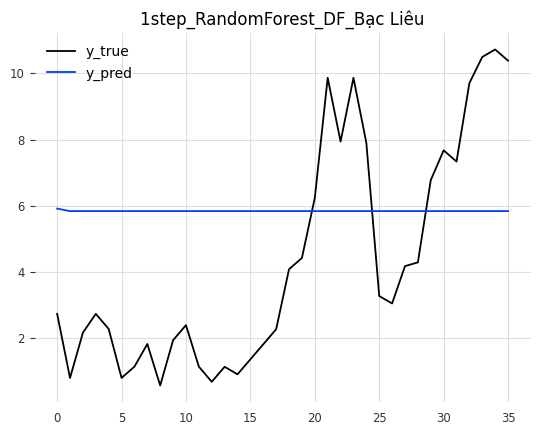

rmse,mae,mape,mse
3.6791368434820146,3.4180925024255355,2.0149649080703096,13.536047913066803
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 232.9359
rmse: 15.262238743012515
mape: 2.6858227959731504


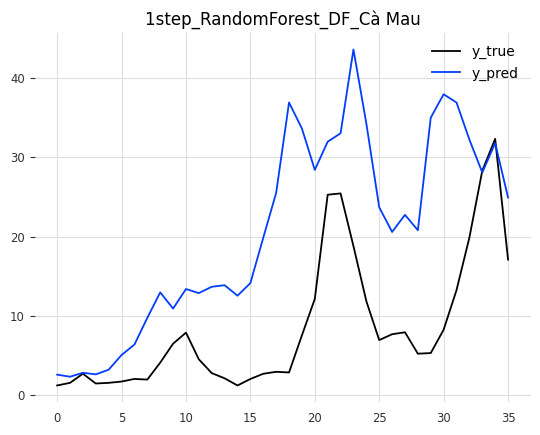

rmse,mae,mape,mse
15.262238743012515,12.083378682232446,2.6858227959731504,232.93593144871224
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 97.4203
rmse: 9.870174076683309
mape: 5.0403534125445235


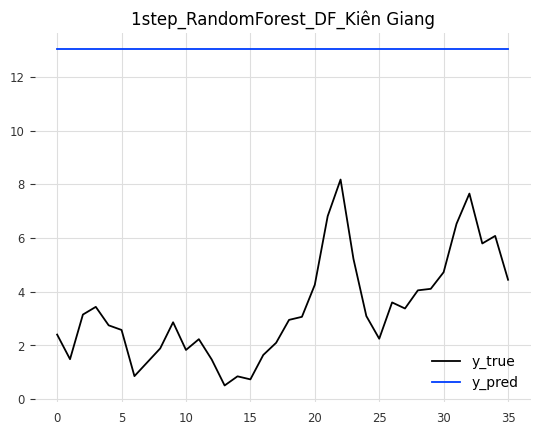

rmse,mae,mape,mse
9.870174076683309,9.674154005425999,5.0403534125445235,97.4203363040312
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 478.7453
rmse: 21.88024873079249
mape: 2.859575992007975


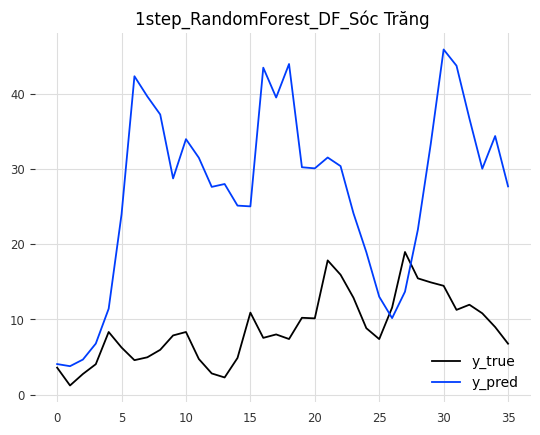

rmse,mae,mape,mse
21.88024873079249,18.75542835304062,2.859575992007975,478.74528452134643
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 178.1741
rmse: 13.348187946877932
mape: 5.8720226851191395


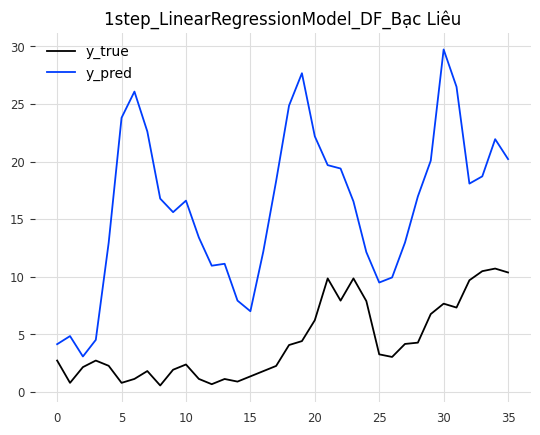

rmse,mae,mape,mse
13.348187946877932,11.738278474383897,5.8720226851191395,178.1741214651773
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 402.7052
rmse: 20.067516323178285
mape: 5.12750541255149


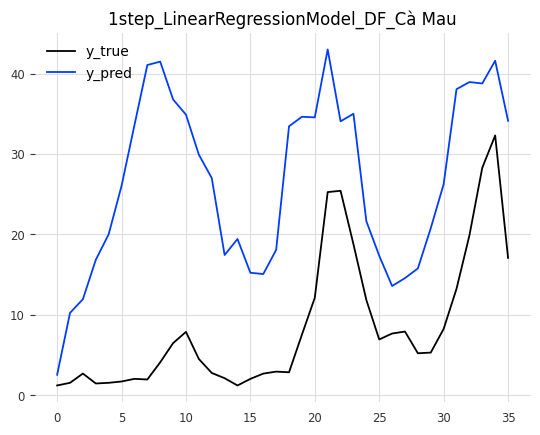

rmse,mae,mape,mse
20.067516323178285,17.96267618302457,5.12750541255149,402.70521138102697
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 441.0661
rmse: 21.001572612030976
mape: 8.413007533086965


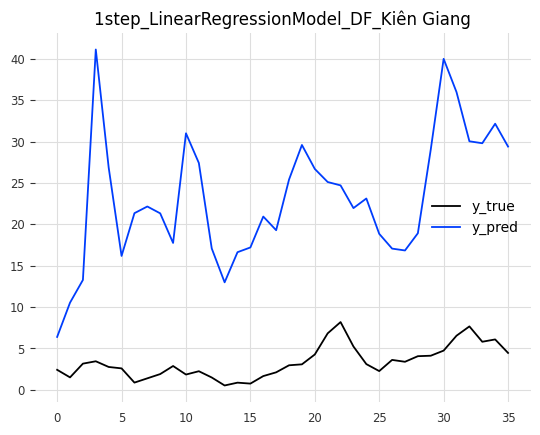

rmse,mae,mape,mse
21.001572612030976,19.82350964802211,8.413007533086965,441.0660521784097
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 418.4637
rmse: 20.45638410369572
mape: 2.3149818602415224


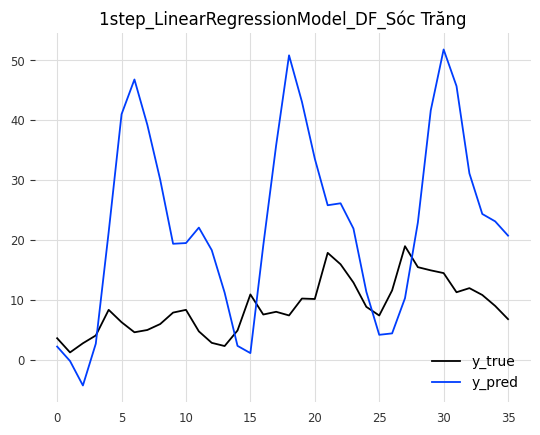

rmse,mae,mape,mse
20.45638410369572,16.41816576386442,2.3149818602415224,418.4636505979349
✨✨✨✨✨✨✨✨LightGBMModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=1.02743036606774e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.02743036606774e-05
[LightGBM] [Warning] feature_fraction is set=0.4595792145776066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4595792145776066
[LightGBM] [Warning] lambda_l1 is set=1.02743036606774e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.02743036606774e-05
[LightGBM] [Warning] feature_fraction is set=0.4595792145776066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4595792145776066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 200, number of 

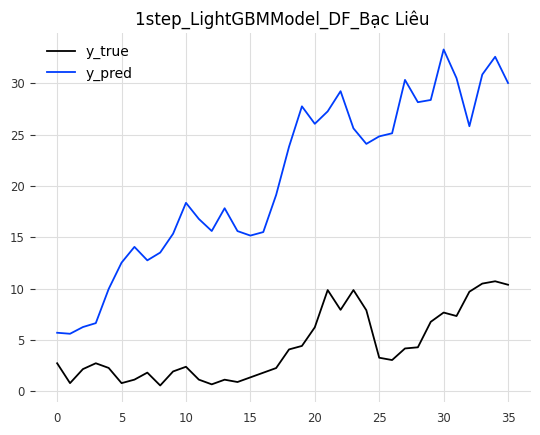

rmse,mae,mape,mse
17.302421040588133,16.206416941682132,6.618999196688376,299.3737738657869
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.001794087726176919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001794087726176919
[LightGBM] [Warning] feature_fraction is set=0.8008951714524423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8008951714524423
[LightGBM] [Warning] lambda_l1 is set=0.001794087726176919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001794087726176919
[LightGBM] [Warning] feature_fraction is set=0.8008951714524423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8008951714524423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 12
[LightGBM] [Inf

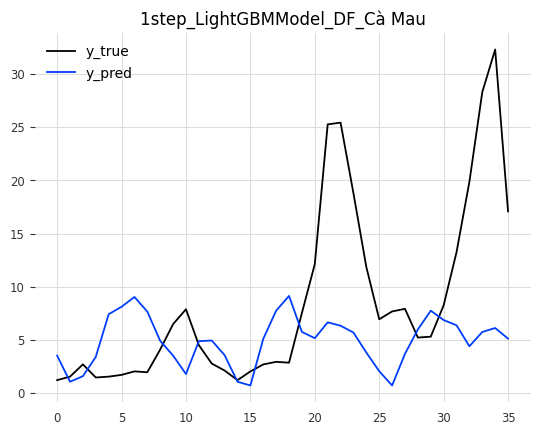

rmse,mae,mape,mse
9.143267958362554,6.411136497525864,1.007310634452314,83.59934895841933
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=9.152120204065056e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.152120204065056e-05
[LightGBM] [Warning] feature_fraction is set=0.50425039154494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50425039154494
[LightGBM] [Warning] lambda_l1 is set=9.152120204065056e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.152120204065056e-05
[LightGBM] [Warning] feature_fraction is set=0.50425039154494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50425039154494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 9
[LightGBM] [Info] 

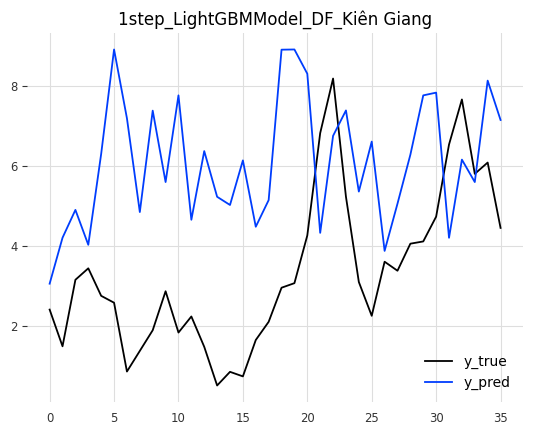

rmse,mae,mape,mse
3.6384922358251504,3.198316064833607,1.8104287944300483,13.238625750159903
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.2962017118124544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2962017118124544
[LightGBM] [Warning] feature_fraction is set=0.1224634541425731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1224634541425731
[LightGBM] [Warning] lambda_l1 is set=0.2962017118124544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2962017118124544
[LightGBM] [Warning] feature_fraction is set=0.1224634541425731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1224634541425731
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 12
[LightGBM] [Info] S

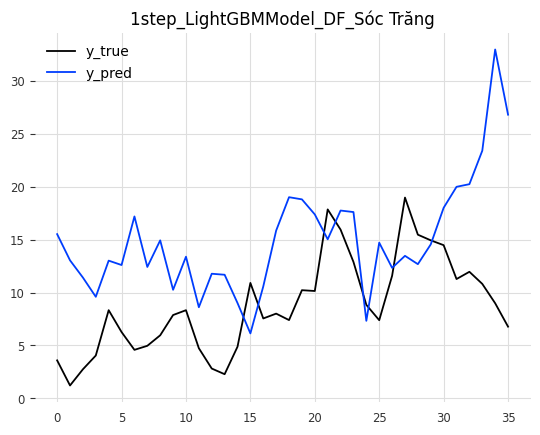

rmse,mae,mape,mse
8.737495252904544,7.208013564002211,1.4012139002103818,76.34382329452944
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 31.7637
rmse: 5.635927486692061
mape: 3.218804156478823


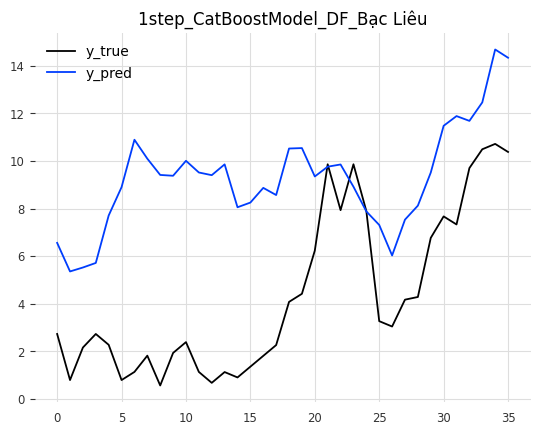

rmse,mae,mape,mse
5.635927486692061,4.981125967674343,3.218804156478823,31.76367863525109
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 65.1567
rmse: 8.071972203363252
mape: 2.0282254019160817


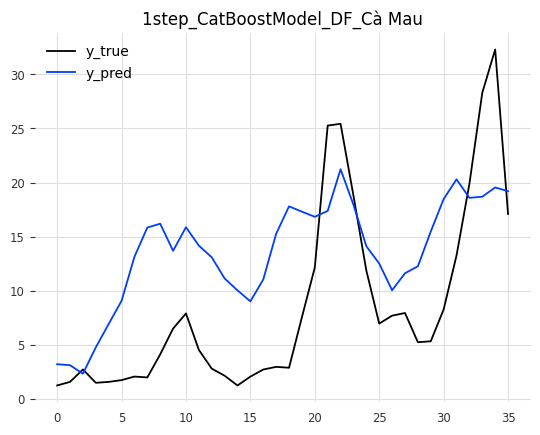

rmse,mae,mape,mse
8.071972203363252,7.047981152361942,2.0282254019160817,65.15673525186901
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 172.6231
rmse: 13.138612454453622
mape: 5.751344616040752


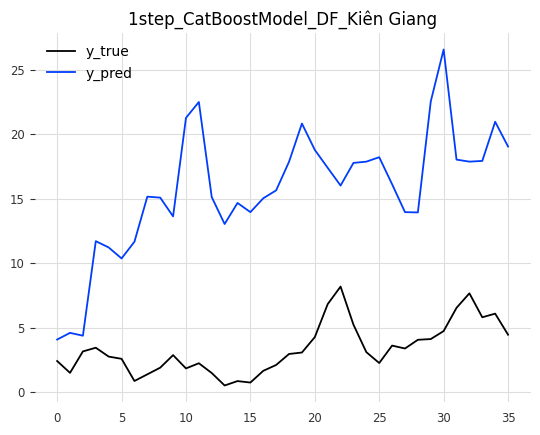

rmse,mae,mape,mse
13.138612454453622,12.332922092925127,5.751344616040752,172.62313722832383
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 216.7693
rmse: 14.723086737681596
mape: 2.3216138382210563


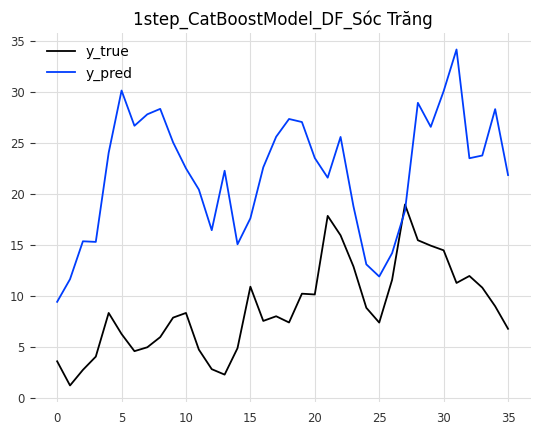

rmse,mae,mape,mse
14.723086737681596,13.3674041444491,2.3216138382210563,216.7692830852957
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 478.0032
rmse: 21.8632837707922
mape: 8.149552862697146


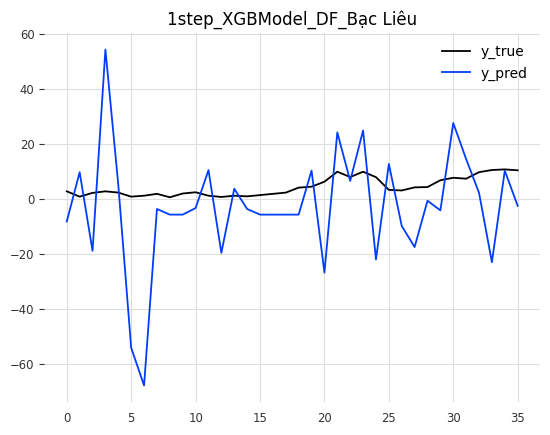

rmse,mae,mape,mse
21.8632837707922,15.422041498246509,8.149552862697146,478.0031772421856
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 6387.0340
rmse: 79.9189211264405
mape: 8.615457514975951


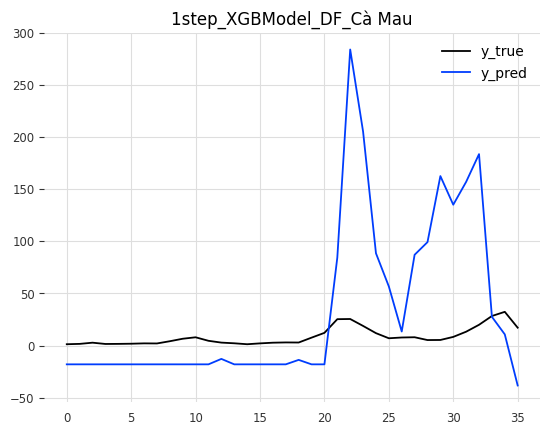

rmse,mae,mape,mse
79.9189211264405,53.390016967627545,8.615457514975951,6387.033954014216
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 3269.7872
rmse: 57.18205296392725
mape: 15.261979790644293


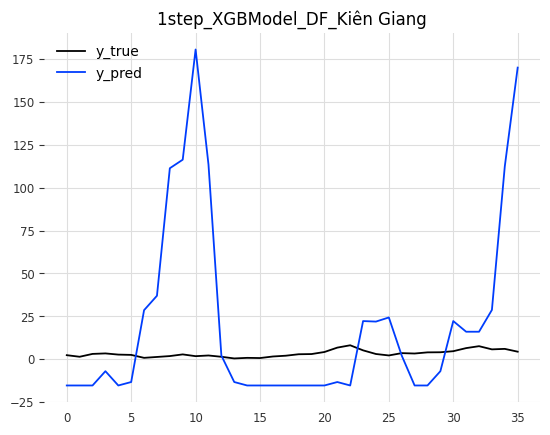

rmse,mae,mape,mse
57.18205296392725,35.88718328236348,15.261979790644293,3269.787181169381
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 11365.5142
rmse: 106.60916559707057
mape: 13.481852987162283


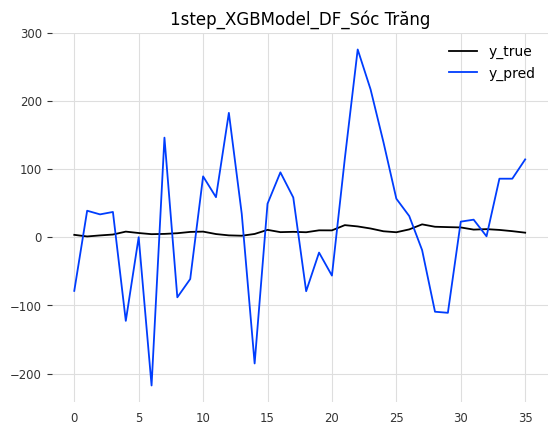

rmse,mae,mape,mse
106.60916559707057,85.84780136673723,13.481852987162283,11365.514189303614
✨✨✨✨✨✨✨✨2✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 13.3126
rmse: 3.648646128032959
mape: 1.9854379964411446


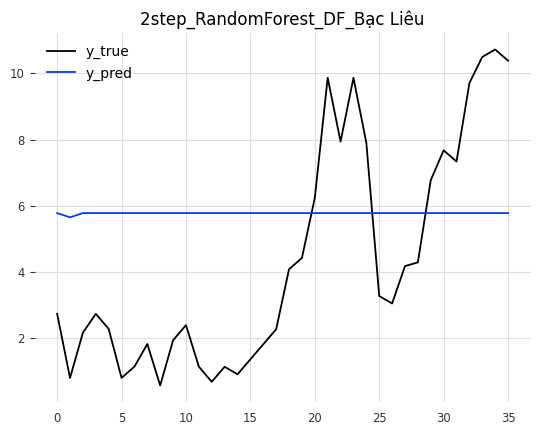

rmse,mae,mape,mse
3.648646128032959,3.3923105099789743,1.9854379964411446,13.312618567609906
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 6776.9949
rmse: 82.32250540534508
mape: 15.96325697648665


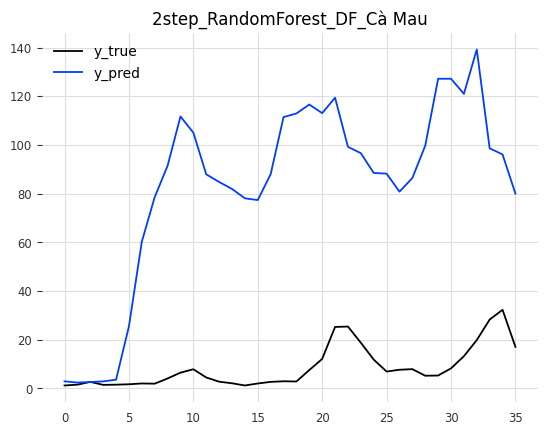

rmse,mae,mape,mse
82.32250540534508,74.45863139455683,15.96325697648665,6776.994896213071
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 99.0904
rmse: 9.95441457568141
mape: 5.0802234445449095


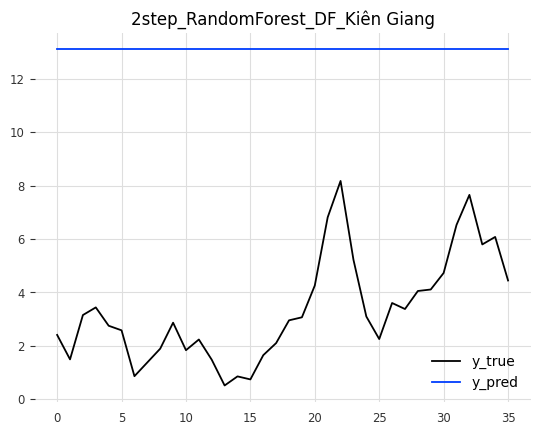

rmse,mae,mape,mse
9.95441457568141,9.76008652426848,5.0802234445449095,99.09036954453849
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 280.0621
rmse: 16.735054697836922
mape: 1.723643845780329


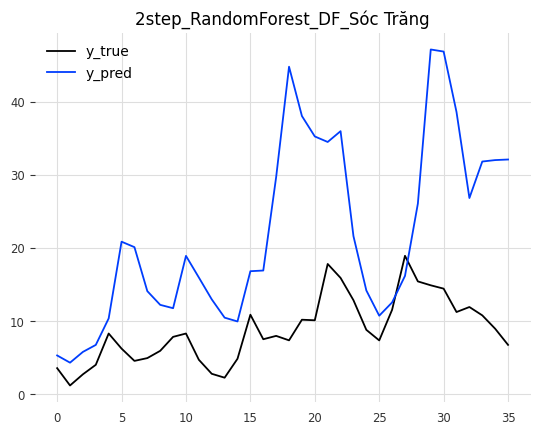

rmse,mae,mape,mse
16.735054697836922,13.347513700312795,1.723643845780329,280.06205573959363
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 202.9477
rmse: 14.245972710254925
mape: 6.8961713561283515


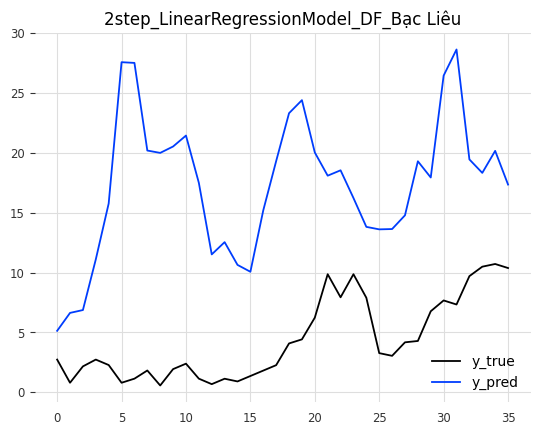

rmse,mae,mape,mse
14.245972710254925,12.969431669243193,6.8961713561283515,202.94773846132807
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 389.4112
rmse: 19.73350433589696
mape: 5.565453385041328


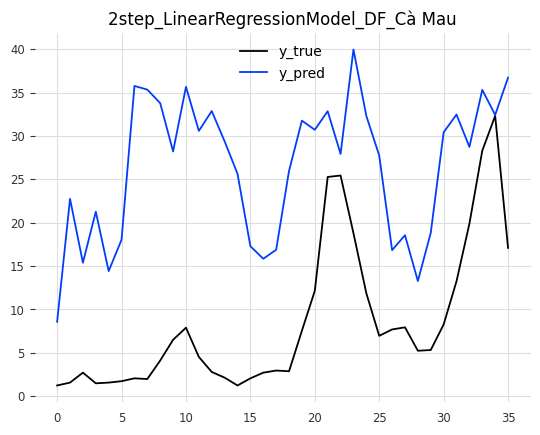

rmse,mae,mape,mse
19.73350433589696,17.861937383027957,5.565453385041328,389.41119337486407
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 355.5675
rmse: 18.856497116063505
mape: 8.11925673613299


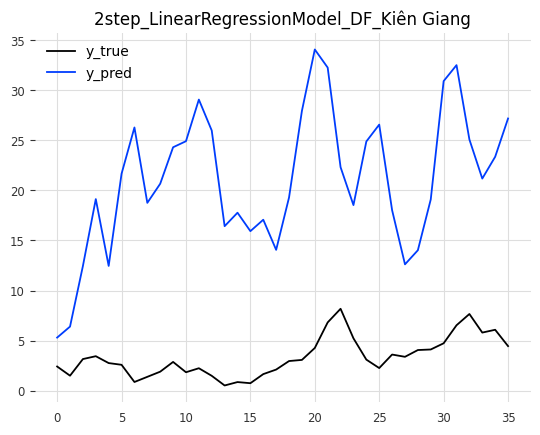

rmse,mae,mape,mse
18.856497116063505,17.732350692937995,8.11925673613299,355.5674834881113
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 402.1141
rmse: 20.052783916401346
mape: 2.440658487029082


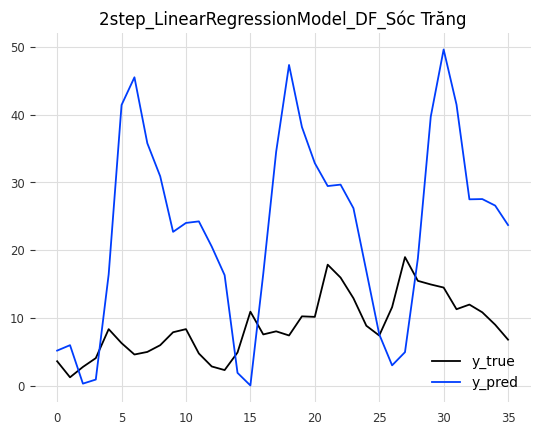

rmse,mae,mape,mse
20.052783916401346,16.75966826047697,2.440658487029082,402.11414279788454
✨✨✨✨✨✨✨✨LightGBMModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=9.010930910097158e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.010930910097158e-05
[LightGBM] [Warning] feature_fraction is set=0.2859362442416458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2859362442416458
[LightGBM] [Warning] lambda_l1 is set=9.010930910097158e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.010930910097158e-05
[LightGBM] [Warning] feature_fraction is set=0.2859362442416458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2859362442416458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 199, numbe

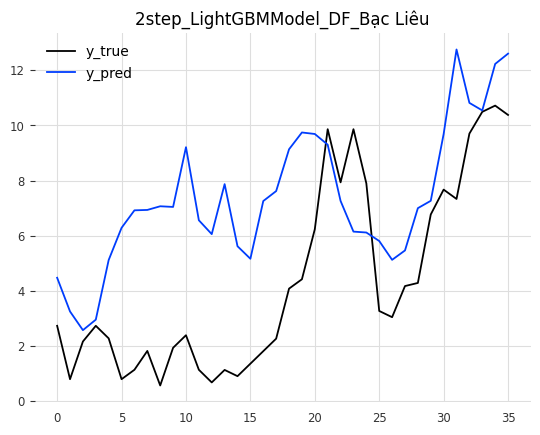

rmse,mae,mape,mse
3.96555134643934,3.370909465746127,2.1265645841095866,15.725597481246862
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.1113663139487229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1113663139487229
[LightGBM] [Warning] feature_fraction is set=0.1045542351285577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1045542351285577
[LightGBM] [Warning] lambda_l1 is set=0.1113663139487229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1113663139487229
[LightGBM] [Warning] feature_fraction is set=0.1045542351285577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1045542351285577
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 13
[LightGBM] [Info] Start 

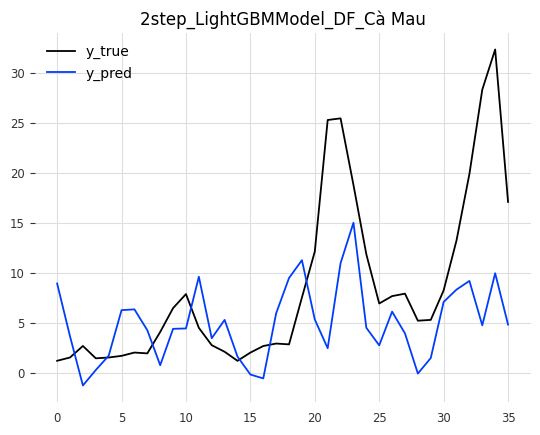

rmse,mae,mape,mse
8.388688534812161,5.891031230417355,0.9970245591941287,70.37009533408899
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=1.223707961129077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.223707961129077
[LightGBM] [Warning] feature_fraction is set=0.6354400075606648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6354400075606648
[LightGBM] [Warning] lambda_l1 is set=1.223707961129077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.223707961129077
[LightGBM] [Warning] feature_fraction is set=0.6354400075606648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6354400075606648
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 10
[LightGBM] [Info] Start 

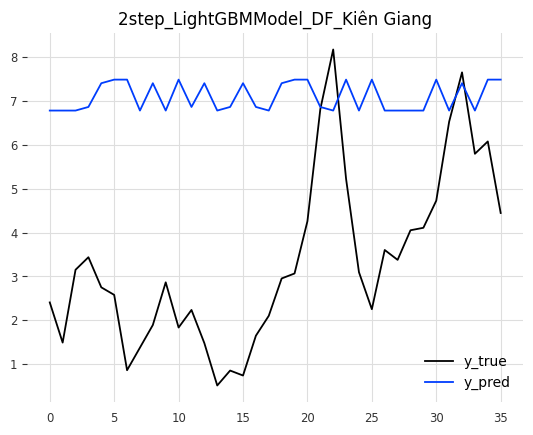

rmse,mae,mape,mse
4.245959653151549,3.8415357130624455,2.2999097114776785,18.028173376190825
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=1.130027818058403e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.130027818058403e-06
[LightGBM] [Warning] feature_fraction is set=0.6952508321548218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6952508321548218
[LightGBM] [Warning] lambda_l1 is set=1.130027818058403e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.130027818058403e-06
[LightGBM] [Warning] feature_fraction is set=0.6952508321548218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6952508321548218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 9
[LightGB

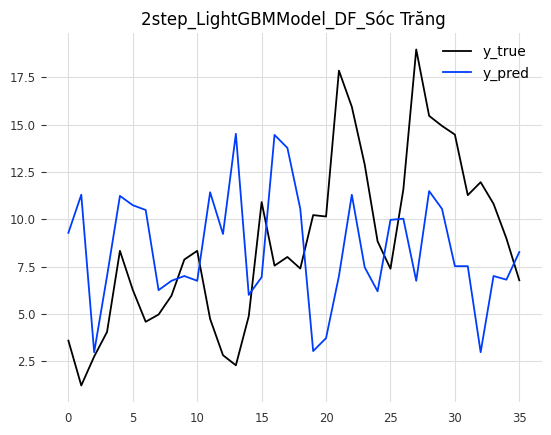

rmse,mae,mape,mse
5.727729221389083,4.778466247222921,0.8987297844390708,32.806882033554395
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 122.1159
rmse: 11.050604444859767
mape: 5.276921353692521


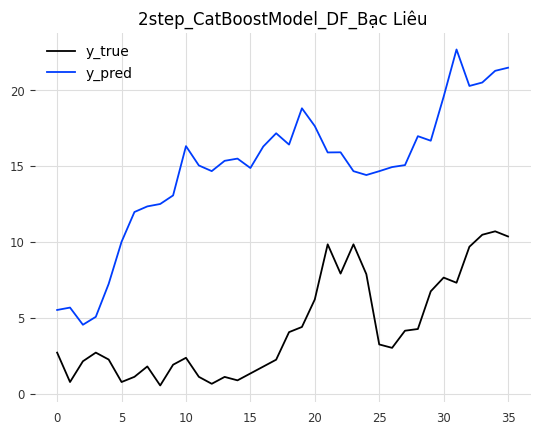

rmse,mae,mape,mse
11.050604444859767,10.408810413690357,5.276921353692521,122.11585859675444
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 81.4538
rmse: 9.025175146592703
mape: 2.5715632350683375


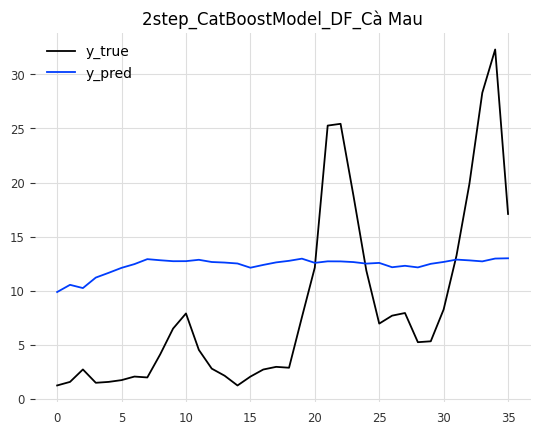

rmse,mae,mape,mse
9.025175146592703,8.140011324564654,2.5715632350683375,81.45378642667463
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 345.1223
rmse: 18.57746773828886
mape: 7.8297969907516


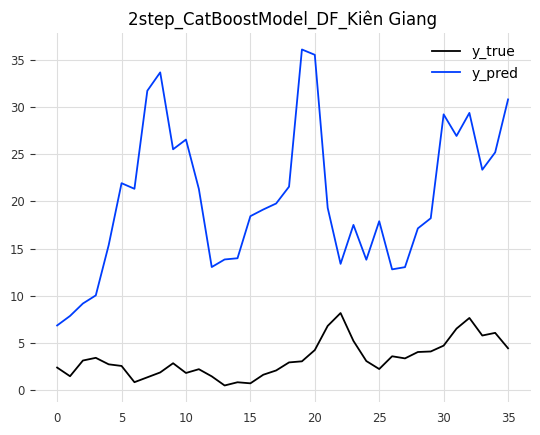

rmse,mae,mape,mse
18.57746773828886,16.943945029410727,7.8297969907516,345.1223075671634
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 225.1682
rmse: 15.005604798854648
mape: 2.3149841752469467


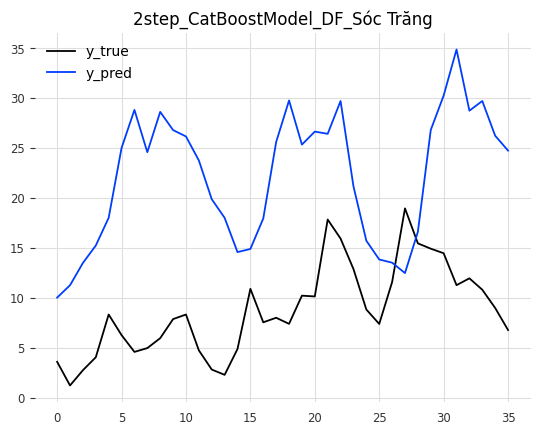

rmse,mae,mape,mse
15.005604798854648,13.71370675582015,2.3149841752469467,225.16817537940963
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 415.4766
rmse: 20.383242639313078
mape: 7.009049104301627


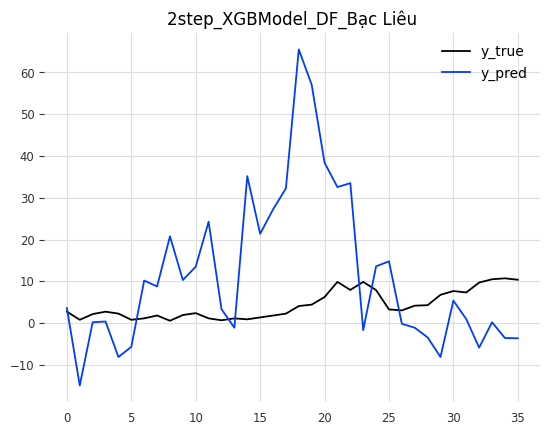

rmse,mae,mape,mse
20.383242639313078,15.226805221864074,7.009049104301627,415.47658049311076
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 5188.7576
rmse: 72.03303135787554
mape: 10.716370742162674


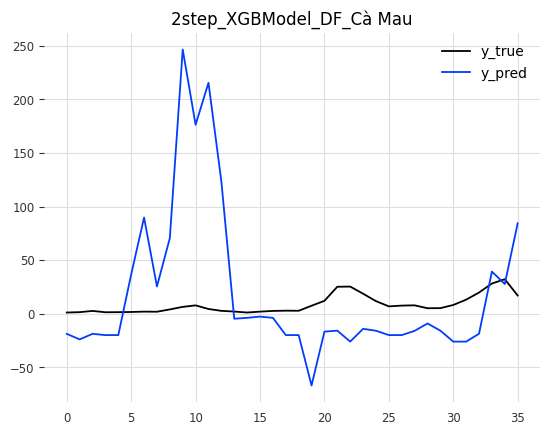

rmse,mae,mape,mse
72.03303135787554,47.084606435609096,10.716370742162674,5188.757606604682
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 12938.6078
rmse: 113.74800142133928
mape: 52.02458547142656


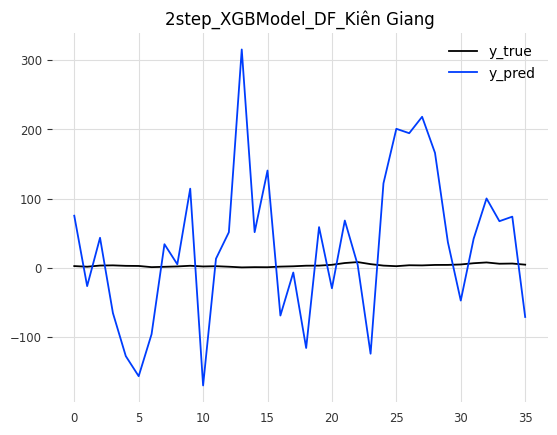

rmse,mae,mape,mse
113.74800142133928,90.82013409440573,52.02458547142656,12938.607827349004
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 7259.5673
rmse: 85.20309440081654
mape: 10.69039381300155


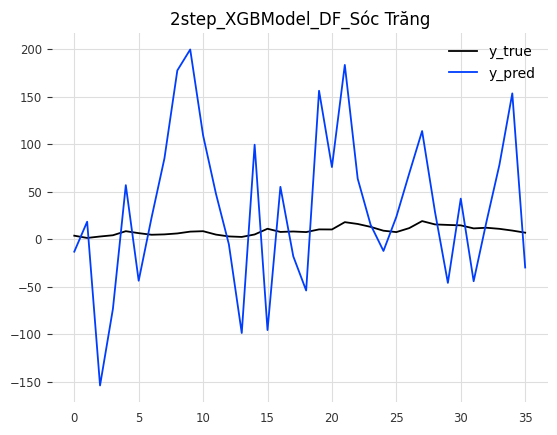

rmse,mae,mape,mse
85.20309440081654,68.00693425190818,10.69039381300155,7259.567295474455
✨✨✨✨✨✨✨✨3✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 13.0383
rmse: 3.6108653566143314
mape: 1.9436790477780983


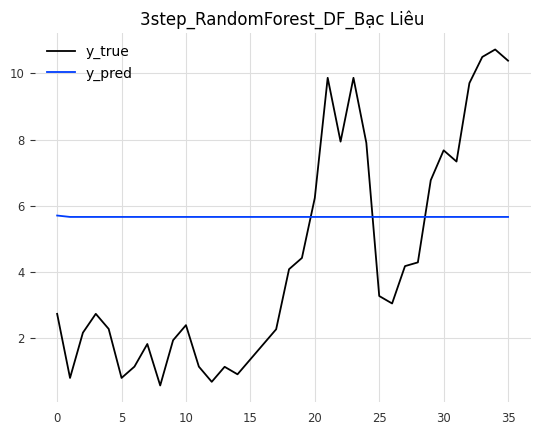

rmse,mae,mape,mse
3.6108653566143314,3.3583760232879634,1.9436790477780983,13.038348623597543
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 130.1458
rmse: 11.40814839328931
mape: 3.710020277291421


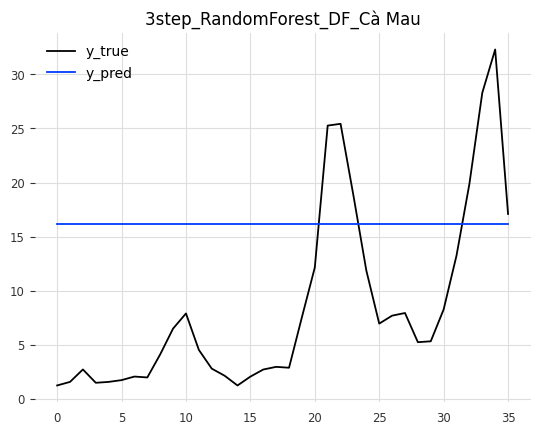

rmse,mae,mape,mse
11.40814839328931,10.642768699730826,3.710020277291421,130.14584976330946
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 91.2810
rmse: 9.554108117814907
mape: 4.890635782199327


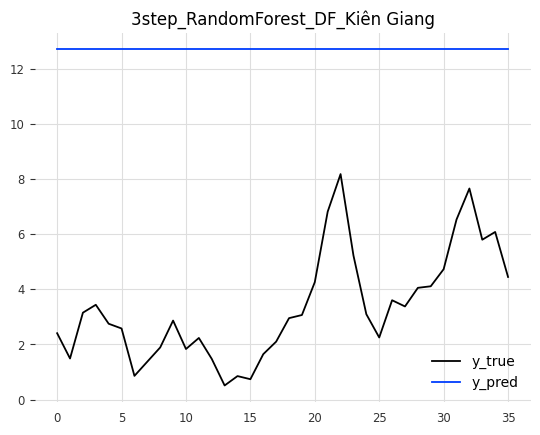

rmse,mae,mape,mse
9.554108117814907,9.351465197687762,4.890635782199327,91.28098192689671
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 419.4503
rmse: 20.480486764678368
mape: 2.4457802717835384


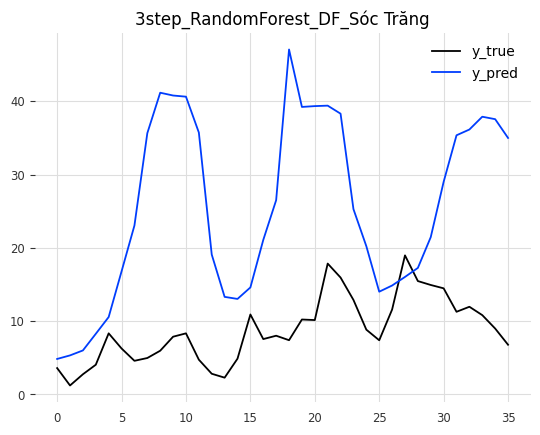

rmse,mae,mape,mse
20.480486764678368,16.958826827584925,2.4457802717835384,419.45033811816586
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 215.3484
rmse: 14.674753528255165
mape: 7.523239943695376


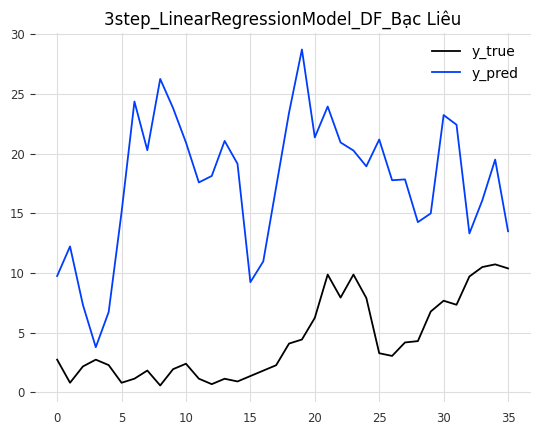

rmse,mae,mape,mse
14.674753528255165,13.299383709384115,7.523239943695376,215.34839111503743
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 407.1949
rmse: 20.179071638280103
mape: 4.508195202357326


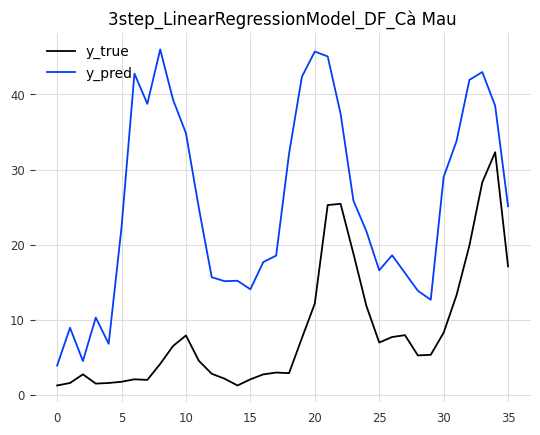

rmse,mae,mape,mse
20.179071638280103,16.990712503791954,4.508195202357326,407.19493218284043
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 376.3705
rmse: 19.400270044761925
mape: 8.962670719188374


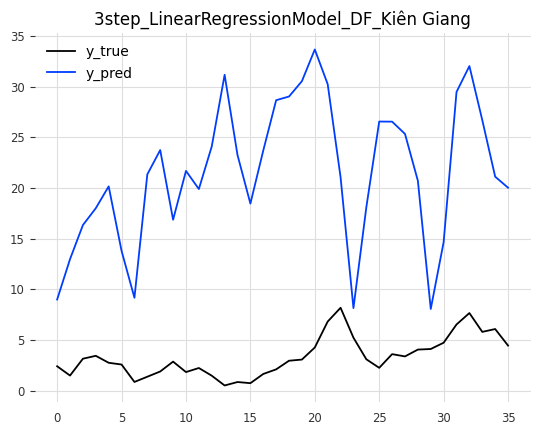

rmse,mae,mape,mse
19.400270044761925,18.154705682497454,8.962670719188374,376.3704778096868
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 314.4287
rmse: 17.73213633418931
mape: 2.601590672603788


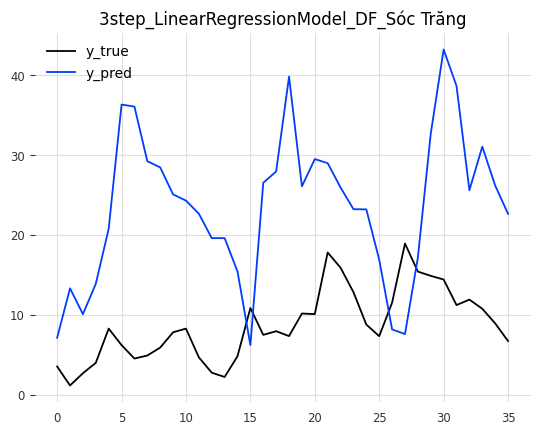

rmse,mae,mape,mse
17.73213633418931,15.953356600436656,2.601590672603788,314.42865897427674
✨✨✨✨✨✨✨✨LightGBMModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=1.10975592999677e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.10975592999677e-08
[LightGBM] [Warning] feature_fraction is set=0.3462047186800969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3462047186800969
[LightGBM] [Warning] lambda_l1 is set=1.10975592999677e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.10975592999677e-08
[LightGBM] [Warning] feature_fraction is set=0.3462047186800969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3462047186800969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 198, number of

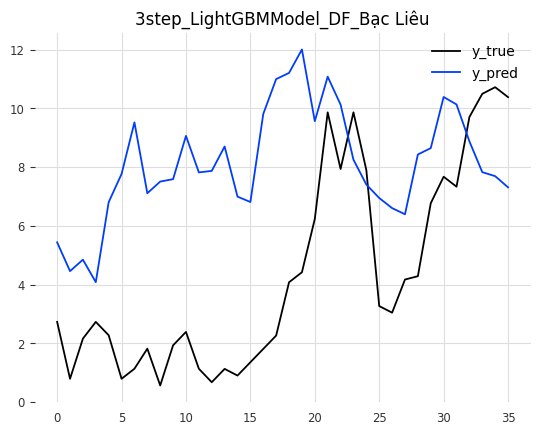

rmse,mae,mape,mse
5.011330394429385,4.407390415915757,2.739705234323677,25.11343232213178
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=2.676933568591416e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676933568591416e-08
[LightGBM] [Warning] feature_fraction is set=0.3000482096717613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3000482096717613
[LightGBM] [Warning] lambda_l1 is set=2.676933568591416e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676933568591416e-08
[LightGBM] [Warning] feature_fraction is set=0.3000482096717613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3000482096717613
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 795
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 14
[LightGBM] [I

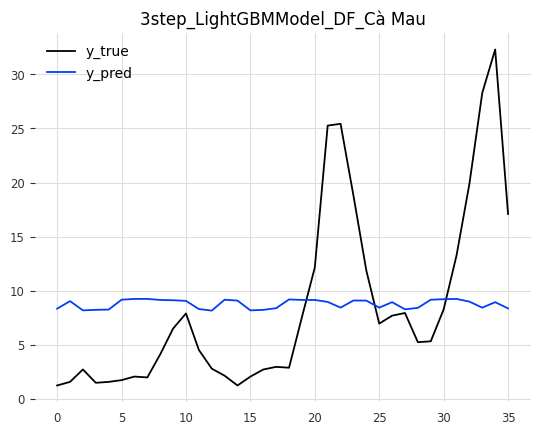

rmse,mae,mape,mse
8.43435822807824,6.6632147703757,1.758999963278162,71.13839871955112
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.004935344186388991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004935344186388991
[LightGBM] [Warning] feature_fraction is set=0.6293849113533706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6293849113533706
[LightGBM] [Warning] lambda_l1 is set=0.004935344186388991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004935344186388991
[LightGBM] [Warning] feature_fraction is set=0.6293849113533706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6293849113533706
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 11
[LightGBM] [Info

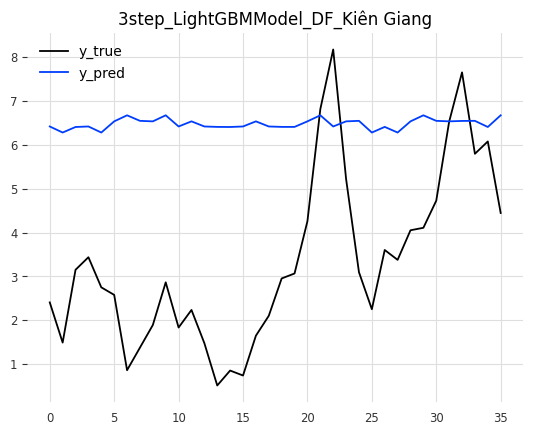

rmse,mae,mape,mse
3.684063691325033,3.304280086817266,2.0215611491250787,13.572325281739428
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=5.13090799863462e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.13090799863462e-07
[LightGBM] [Warning] feature_fraction is set=0.1027789853174643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1027789853174643
[LightGBM] [Warning] lambda_l1 is set=5.13090799863462e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.13090799863462e-07
[LightGBM] [Warning] feature_fraction is set=0.1027789853174643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1027789853174643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 14
[LightGBM] [

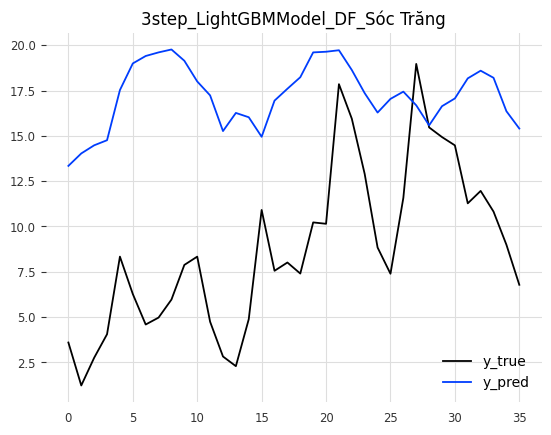

rmse,mae,mape,mse
9.469602575935422,8.596617298017746,1.7635362024352426,89.67337294616277
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 20.3973
rmse: 4.516341771960836
mape: 2.239942806561226


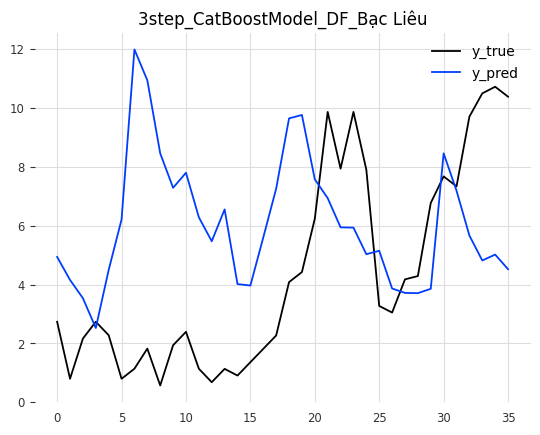

rmse,mae,mape,mse
4.516341771960836,3.779038090784417,2.239942806561226,20.397343001158347
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 429.5757
rmse: 20.72620794443158
mape: 5.149716935397791


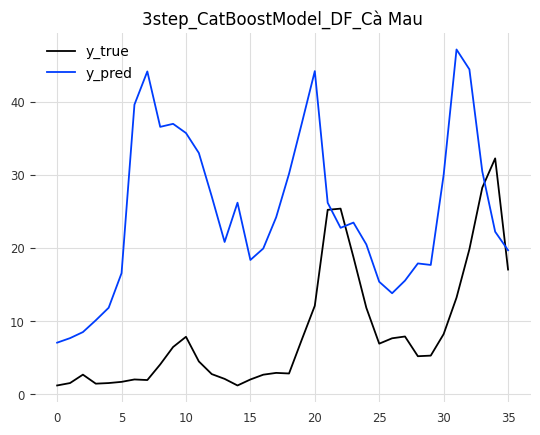

rmse,mae,mape,mse
20.72620794443158,17.29591492647677,5.149716935397791,429.5756957558187
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 169.8630
rmse: 13.033149141738743
mape: 6.117146018735385


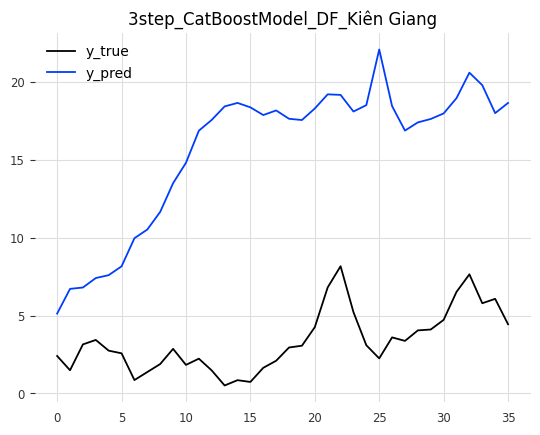

rmse,mae,mape,mse
13.033149141738743,12.312075491880966,6.117146018735385,169.86297655080534
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 132.9833
rmse: 11.531837399963448
mape: 1.9938619537876738


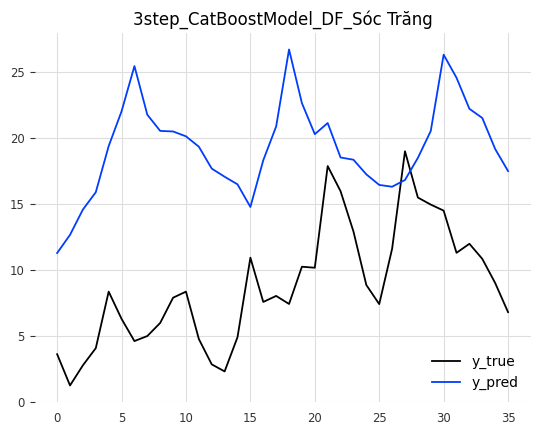

rmse,mae,mape,mse
11.531837399963448,10.61028645112739,1.9938619537876738,132.98327381919574
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 1754.0422
rmse: 41.88128698923327
mape: 17.49880899878757


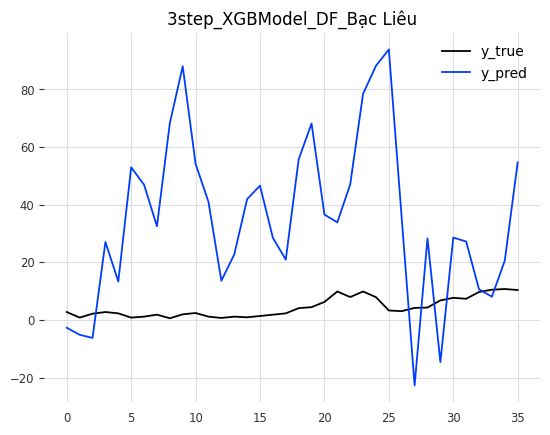

rmse,mae,mape,mse
41.88128698923327,34.63526185747341,17.49880899878757,1754.0421998745196
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 2782.9878
rmse: 52.75403130188491
mape: 12.864570046734666


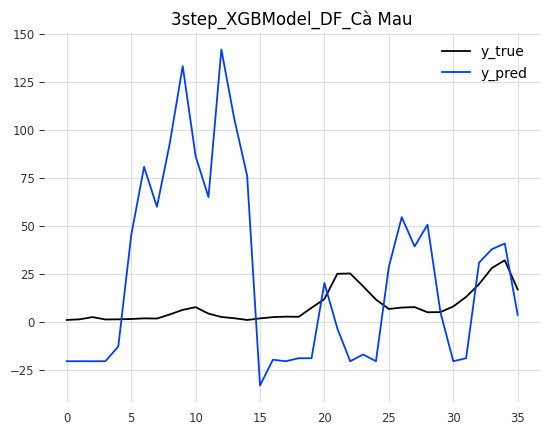

rmse,mae,mape,mse
52.75403130188491,41.2384436378722,12.864570046734666,2782.9878186002525
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 28091.1434
rmse: 167.60412699814404
mape: 60.415550855363705


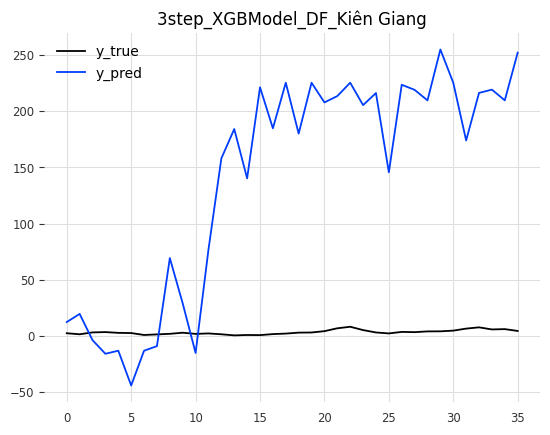

rmse,mae,mape,mse
167.60412699814404,143.61747368998493,60.415550855363705,28091.14338681
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 10877.3614
rmse: 104.29458956347894
mape: 11.575321480585547


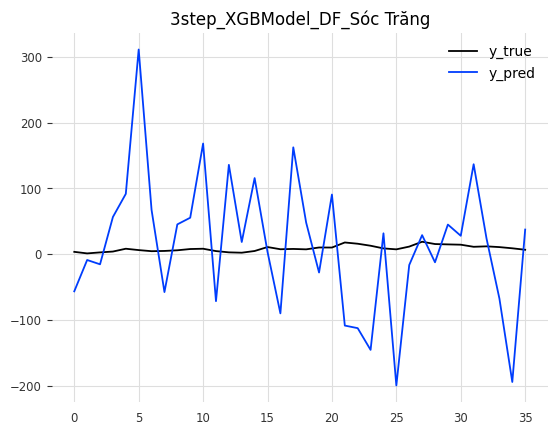

rmse,mae,mape,mse
104.29458956347894,79.45767306019087,11.575321480585547,10877.36141221453
✨✨✨✨✨✨✨✨4✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 13.5287
rmse: 3.6781428737134623
mape: 2.0149837076769774


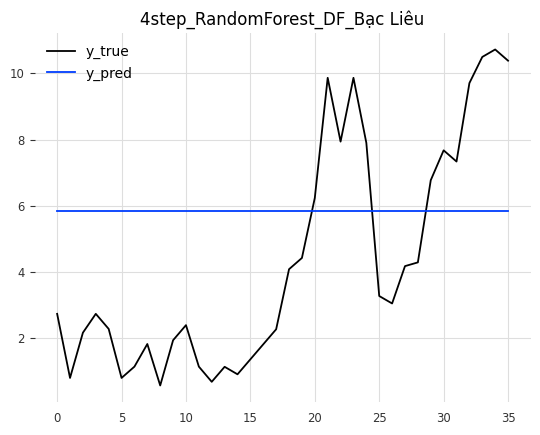

rmse,mae,mape,mse
3.6781428737134623,3.4166601792477254,2.0149837076769774,13.528734999449128
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 118.3728
rmse: 10.879927512879473
mape: 3.4935199281014864


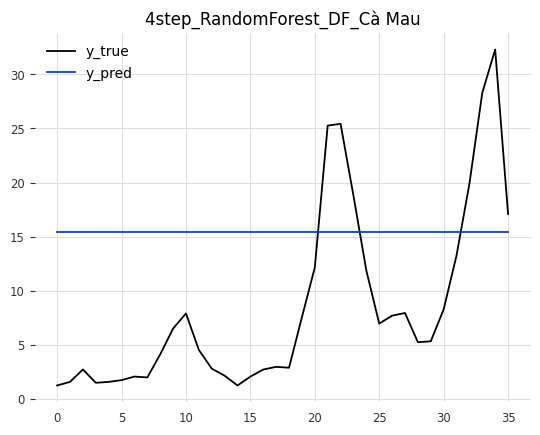

rmse,mae,mape,mse
10.879927512879473,10.146864670197465,3.4935199281014864,118.3728226855117
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 98.8803
rmse: 9.943857167331098
mape: 5.075227499060073


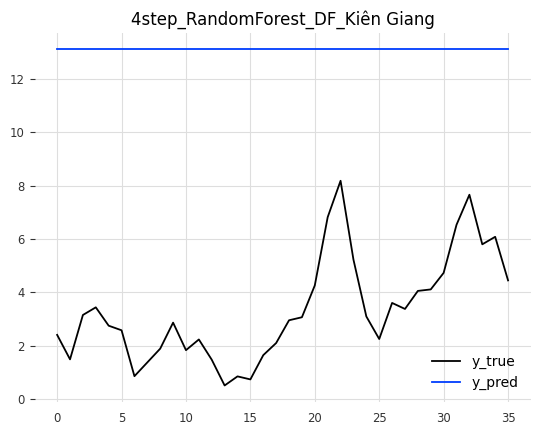

rmse,mae,mape,mse
9.943857167331098,9.749318682910653,5.075227499060073,98.88029536428205
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 428.9230
rmse: 20.710457280001098
mape: 2.675250826275649


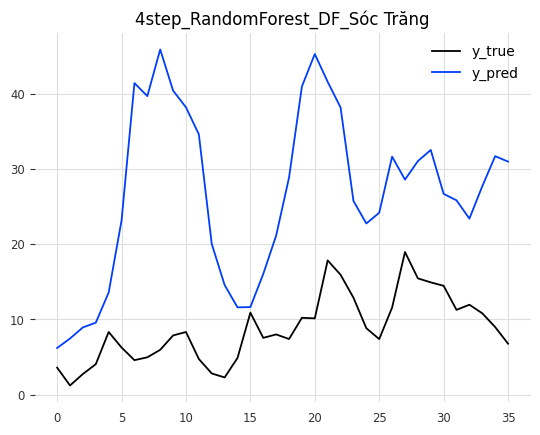

rmse,mae,mape,mse
20.710457280001098,17.974386253879302,2.675250826275649,428.9230407467505
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 187.0160
rmse: 13.67537849122831
mape: 7.083681471100211


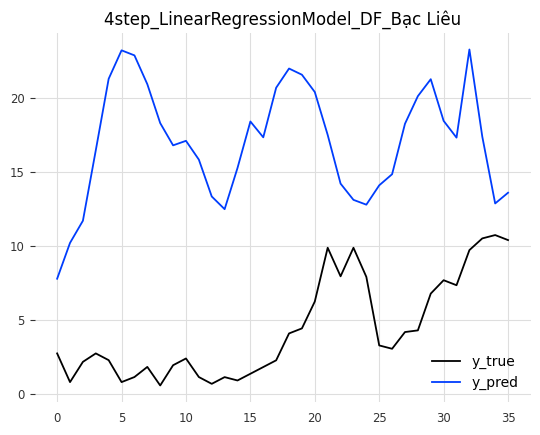

rmse,mae,mape,mse
13.67537849122831,12.65129443277733,7.083681471100211,187.0159768783499
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 231.8156
rmse: 15.225490399320003
mape: 3.556459166473454


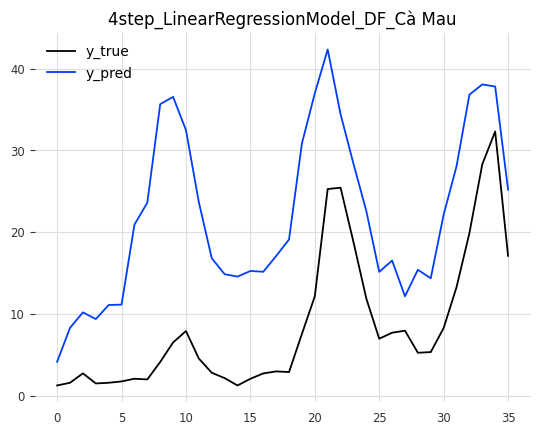

rmse,mae,mape,mse
15.225490399320003,13.59998879860455,3.556459166473454,231.8155578997856
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 319.0621
rmse: 17.86230924909612
mape: 8.812956177492365


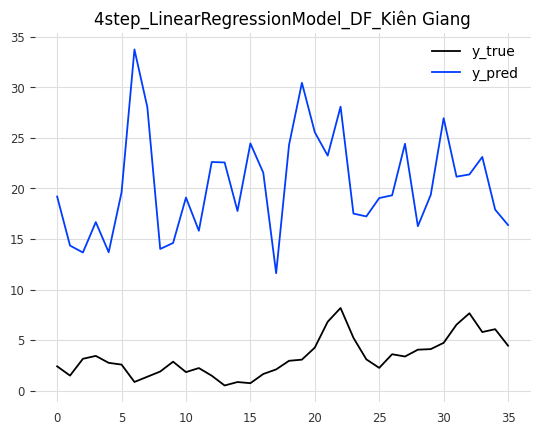

rmse,mae,mape,mse
17.86230924909612,17.069967252536294,8.812956177492365,319.0620917103448
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 334.7049
rmse: 18.294941299768162
mape: 2.8484162129565944


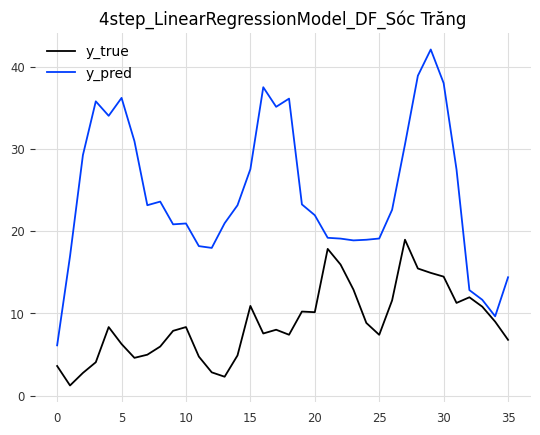

rmse,mae,mape,mse
18.294941299768162,15.790674891951227,2.8484162129565944,334.7048771619627
✨✨✨✨✨✨✨✨LightGBMModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=5.705962351344432e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.705962351344432e-08
[LightGBM] [Warning] feature_fraction is set=0.5097817663985453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097817663985453
[LightGBM] [Warning] lambda_l1 is set=5.705962351344432e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.705962351344432e-08
[LightGBM] [Warning] feature_fraction is set=0.5097817663985453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097817663985453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 197, numb

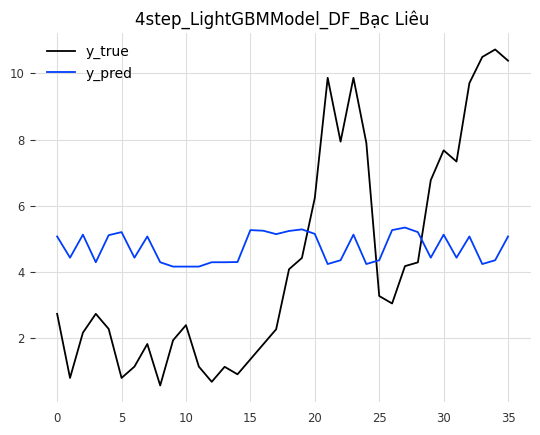

rmse,mae,mape,mse
3.4203448627051034,3.1062836316153577,1.5319496819682645,11.698758979833192
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=2.980323270879699e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.980323270879699e-05
[LightGBM] [Warning] feature_fraction is set=0.2501354142328944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2501354142328944
[LightGBM] [Warning] lambda_l1 is set=2.980323270879699e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.980323270879699e-05
[LightGBM] [Warning] feature_fraction is set=0.2501354142328944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2501354142328944
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 197, number of used features: 15
[LightGBM

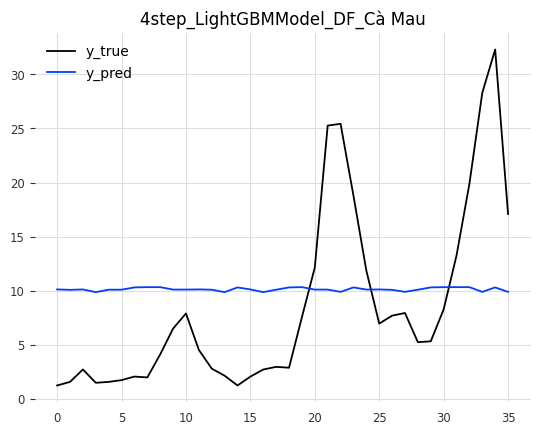

rmse,mae,mape,mse
8.609033801204106,7.31837258471413,2.119392639100354,74.11546299027482
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.6721066775566634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6721066775566634
[LightGBM] [Warning] feature_fraction is set=0.8659351753935054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8659351753935054
[LightGBM] [Warning] lambda_l1 is set=0.6721066775566634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6721066775566634
[LightGBM] [Warning] feature_fraction is set=0.8659351753935054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8659351753935054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 197, number of used features: 15
[LightGBM] [Info] Star

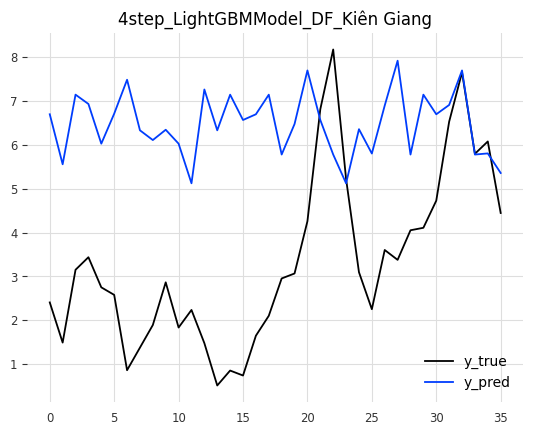

rmse,mae,mape,mse
3.787975161451671,3.3030236790946783,2.056332016198178,14.348755823774813
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.4061641772073959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4061641772073959
[LightGBM] [Warning] feature_fraction is set=0.8645021162872435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8645021162872435
[LightGBM] [Warning] lambda_l1 is set=0.4061641772073959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4061641772073959
[LightGBM] [Warning] feature_fraction is set=0.8645021162872435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8645021162872435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 197, number of used features: 15
[LightGBM] [Info] St

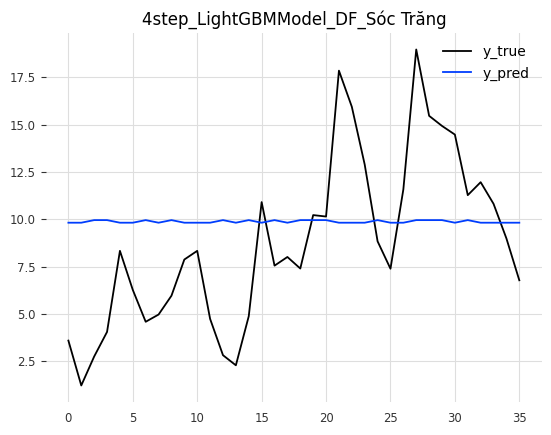

rmse,mae,mape,mse
4.599811553020928,3.8548995297743573,0.8299595666856084,21.158266323304794
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 37.2297
rmse: 6.101616880659833
mape: 2.359505252968278


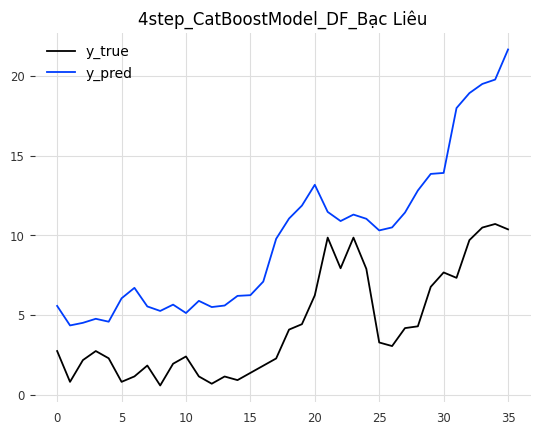

rmse,mae,mape,mse
6.101616880659833,5.534735133017223,2.359505252968278,37.22972855835303
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 83.0537
rmse: 9.113381056477506
mape: 2.577208358650756


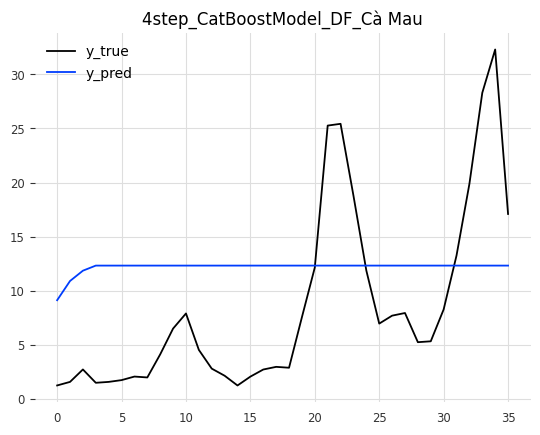

rmse,mae,mape,mse
9.113381056477506,8.183475659407518,2.577208358650756,83.05371428056307
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 180.6684
rmse: 13.441296081928943
mape: 6.435706944433046


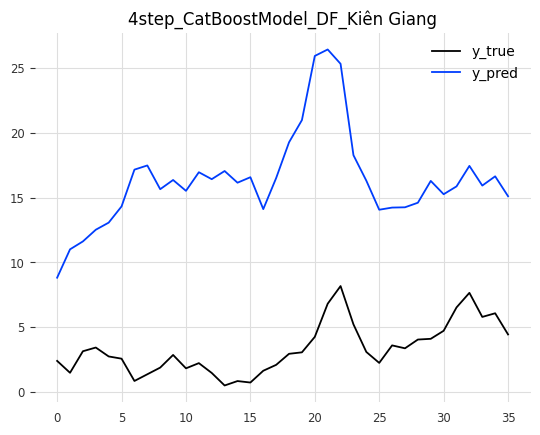

rmse,mae,mape,mse
13.441296081928943,13.026464350397228,6.435706944433046,180.66844036207834
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 177.5347
rmse: 13.324213428979181
mape: 2.2396431873496856


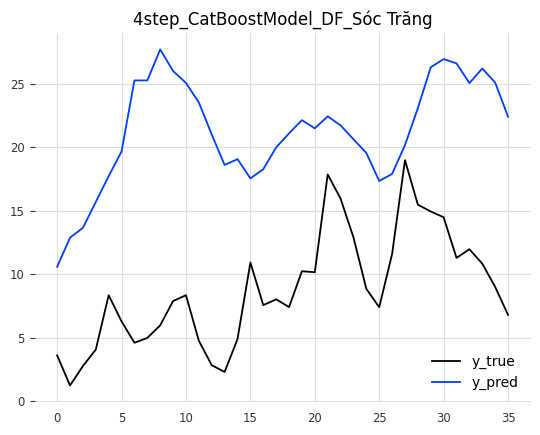

rmse,mae,mape,mse
13.324213428979181,12.45326723639062,2.2396431873496856,177.53466350098915
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 1910.4254
rmse: 43.708412860751224
mape: 18.909031576018112


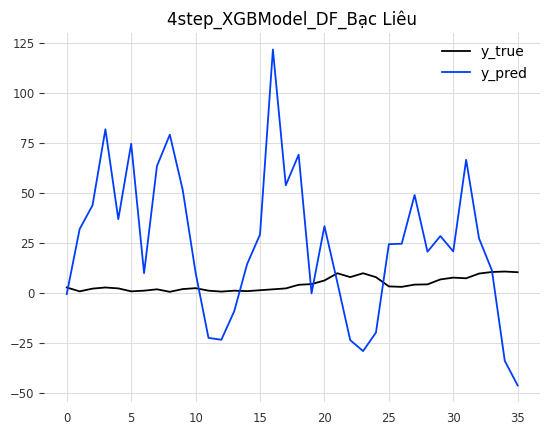

rmse,mae,mape,mse
43.708412860751224,34.99019419765315,18.909031576018112,1910.4253548058832
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 10057.3036
rmse: 100.28610861181653
mape: 10.807453445990474


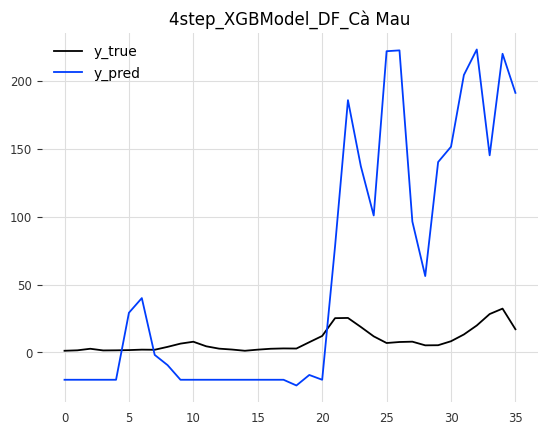

rmse,mae,mape,mse
100.28610861181653,73.1524720679176,10.807453445990474,10057.303580501062
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 5637.8960
rmse: 75.08592416509022
mape: 17.98735478219341


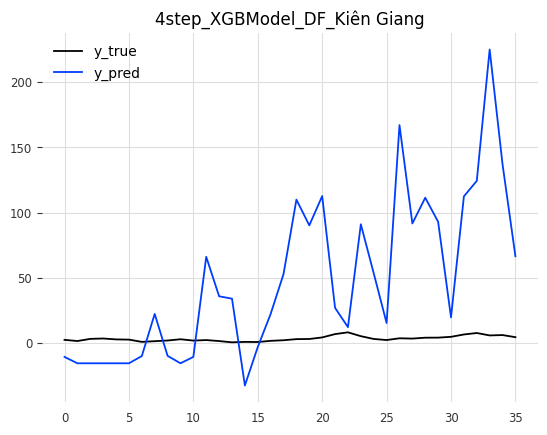

rmse,mae,mape,mse
75.08592416509022,55.36204151712742,17.98735478219341,5637.896007725679
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 3341.2697
rmse: 57.80371720258722
mape: 5.784724603799123


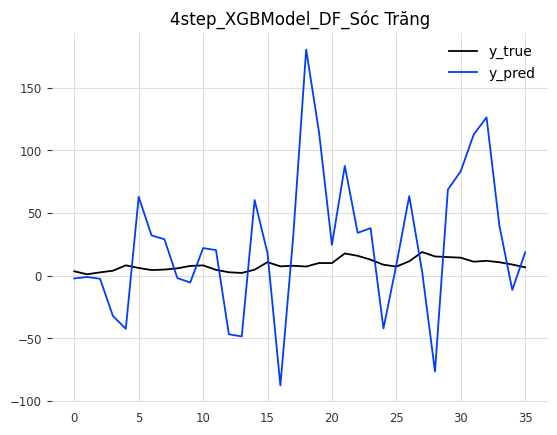

rmse,mae,mape,mse
57.80371720258722,43.26951757712645,5.784724603799123,3341.269722436678
✨✨✨✨✨✨✨✨5✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 67.3332
rmse: 8.205682467083486
mape: 3.826658016775309


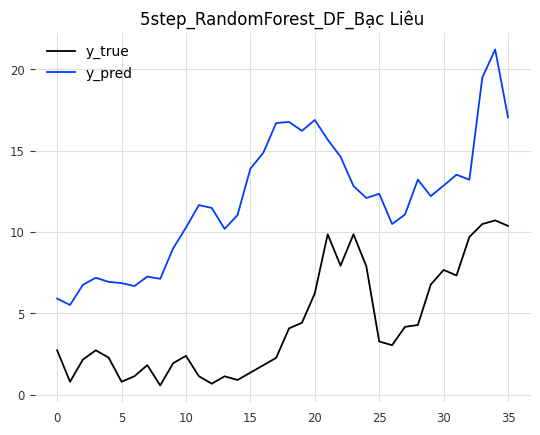

rmse,mae,mape,mse
8.205682467083486,7.624395408437099,3.826658016775309,67.33322475060133
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 349.5985
rmse: 18.697552789755587
mape: 4.959557847642691


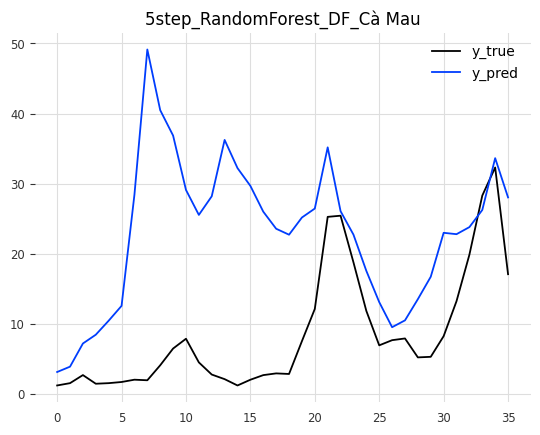

rmse,mae,mape,mse
18.697552789755587,14.581364515243987,4.959557847642691,349.5984803256969
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 2707.4678
rmse: 52.033333532126065
mape: 19.518432183866654


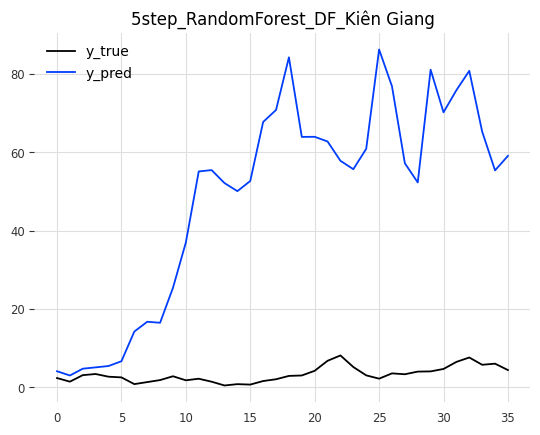

rmse,mae,mape,mse
52.033333532126065,45.380759845230045,19.518432183866654,2707.467798465475
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 44.2535
rmse: 6.652328882129532
mape: 1.0089292664585137


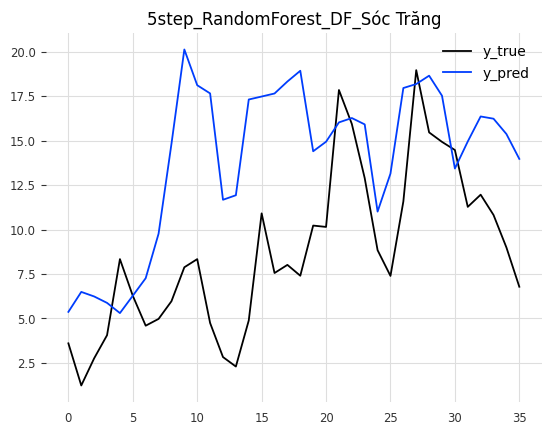

rmse,mae,mape,mse
6.652328882129532,5.5361858388347605,1.0089292664585137,44.25347955601475
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 185.1680
rmse: 13.607645222212065
mape: 6.6150218583662985


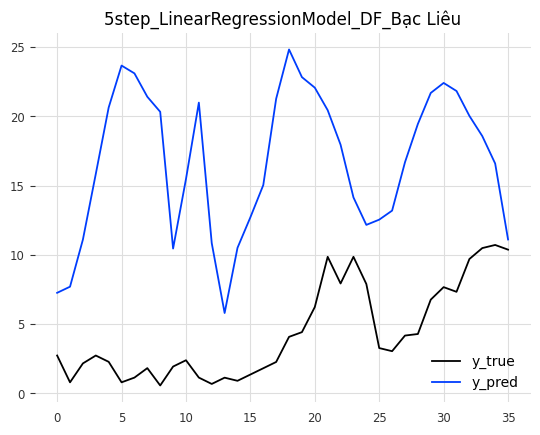

rmse,mae,mape,mse
13.607645222212065,12.393897232756228,6.6150218583662985,185.16800849359086
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 200.2190
rmse: 14.149876803444897
mape: 4.041799031007962


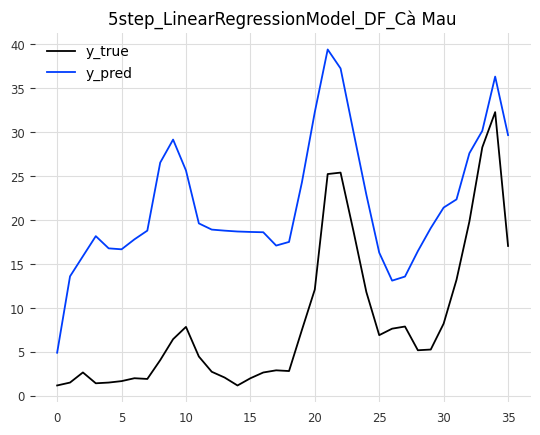

rmse,mae,mape,mse
14.149876803444897,13.27955539024126,4.041799031007962,200.219013552668
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 294.4379
rmse: 17.159192504046146
mape: 7.102665194114114


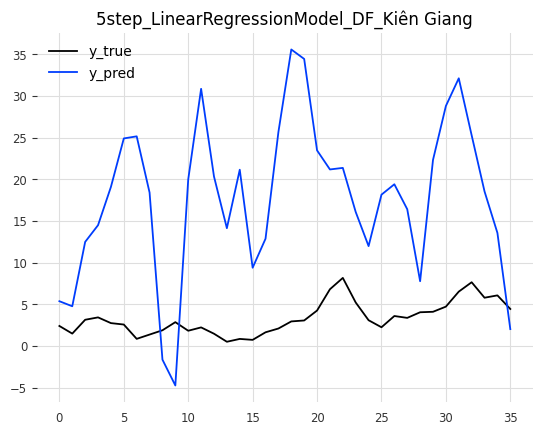

rmse,mae,mape,mse
17.159192504046146,15.229495059781694,7.102665194114114,294.4378873909135
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 323.0318
rmse: 17.97308474318174
mape: 2.3848869106107458


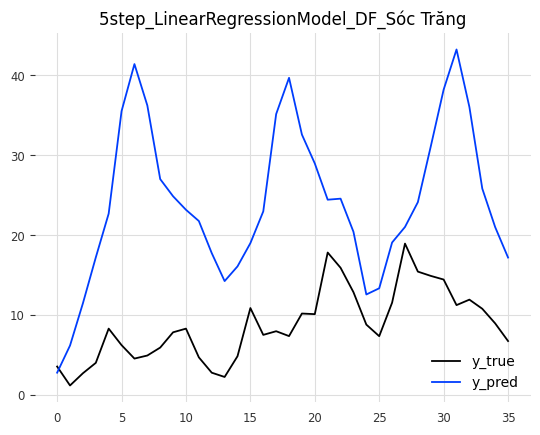

rmse,mae,mape,mse
17.97308474318174,15.454359823517851,2.3848869106107458,323.0317751855922
✨✨✨✨✨✨✨✨LightGBMModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=6.609730177397313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.609730177397313
[LightGBM] [Warning] feature_fraction is set=0.5196489057558623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5196489057558623
[LightGBM] [Warning] lambda_l1 is set=6.609730177397313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.609730177397313
[LightGBM] [Warning] feature_fraction is set=0.5196489057558623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5196489057558623
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 745
[LightGBM] [Info] Number of data points in the train set: 196, number of used featur

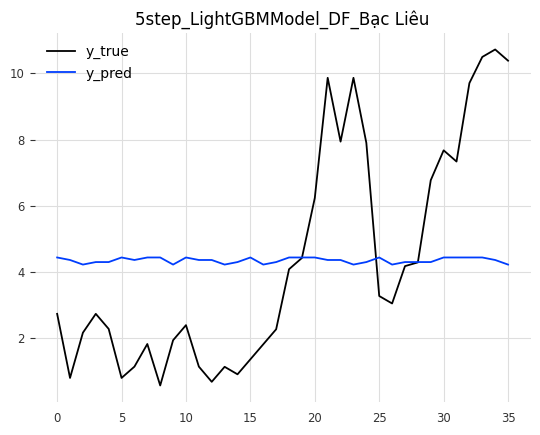

rmse,mae,mape,mse
3.3636558569413,2.91357165570491,1.4170148386984531,11.314180723935513
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.8991369943774201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8991369943774201
[LightGBM] [Warning] feature_fraction is set=0.5567372675928864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5567372675928864
[LightGBM] [Warning] lambda_l1 is set=0.8991369943774201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8991369943774201
[LightGBM] [Warning] feature_fraction is set=0.5567372675928864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5567372675928864
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 196, number of used features: 14
[LightGBM] [Info] Start tr

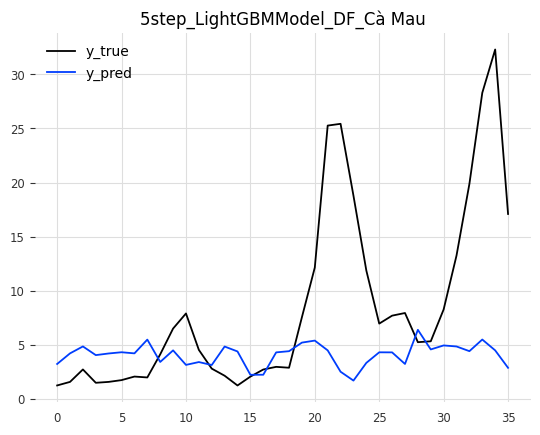

rmse,mae,mape,mse
9.630535667305782,6.158113702369432,0.7957565050978835,92.74721723924881
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=6.804905187899507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.804905187899507
[LightGBM] [Warning] feature_fraction is set=0.9156056292298111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9156056292298111
[LightGBM] [Warning] lambda_l1 is set=6.804905187899507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.804905187899507
[LightGBM] [Warning] feature_fraction is set=0.9156056292298111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9156056292298111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 196, number of used features: 16
[LightGBM] [Info] Start 

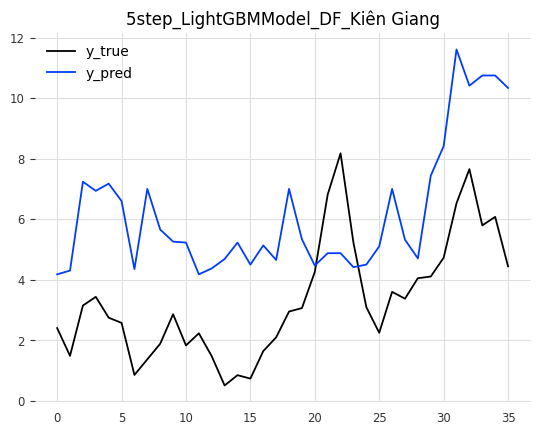

rmse,mae,mape,mse
3.4748429064768316,3.2142507162963656,1.6005157324689963,12.074533224692356
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.0003282868894611527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003282868894611527
[LightGBM] [Warning] feature_fraction is set=0.9195430416793863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9195430416793863
[LightGBM] [Warning] lambda_l1 is set=0.0003282868894611527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003282868894611527
[LightGBM] [Warning] feature_fraction is set=0.9195430416793863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9195430416793863
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 196, number of used features: 16
[Light

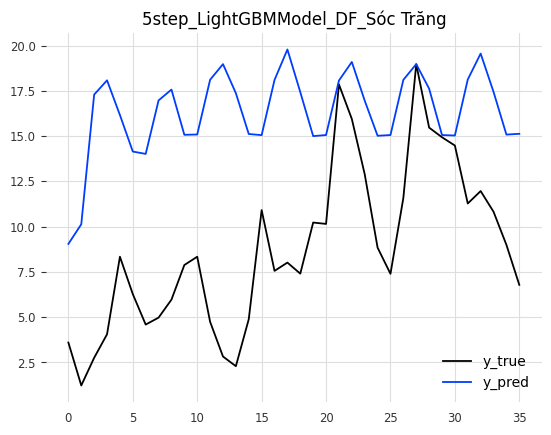

rmse,mae,mape,mse
8.687471954673654,7.575145722600458,1.5948171281771892,75.47216896324127
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 102.0506
rmse: 10.102008436964002
mape: 3.260148470149802


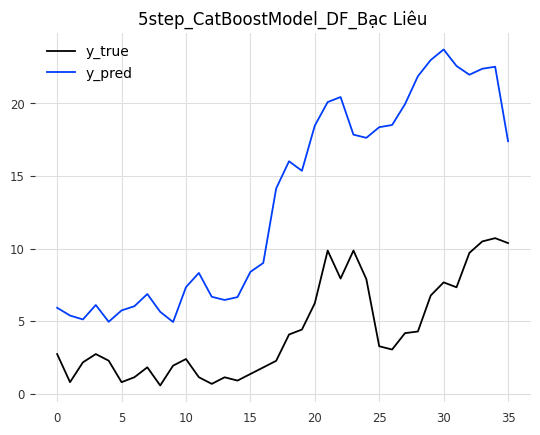

rmse,mae,mape,mse
10.102008436964002,9.030162046549215,3.260148470149802,102.05057446049189
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 118.4247
rmse: 10.882310472787406
mape: 3.1453403679793417


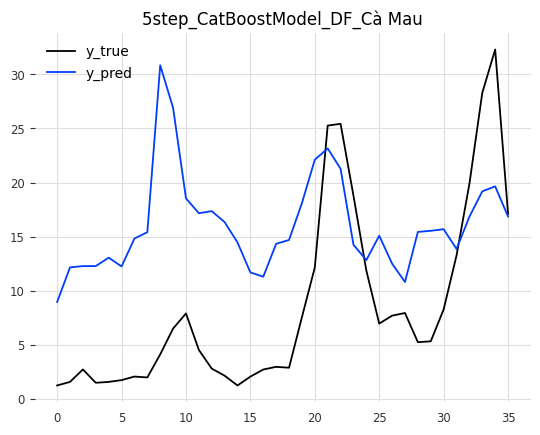

rmse,mae,mape,mse
10.882310472787406,9.509649495402918,3.1453403679793417,118.42468122613847
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 176.3114
rmse: 13.278230761506391
mape: 5.922735640959318


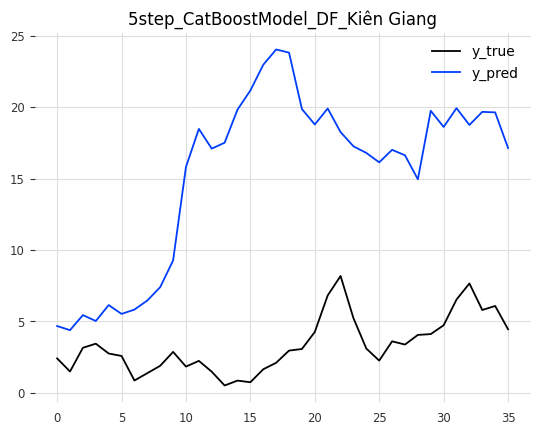

rmse,mae,mape,mse
13.278230761506391,11.930991944113067,5.922735640959318,176.3114121558146
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 83.7976
rmse: 9.15410447898193
mape: 1.7948222859219531


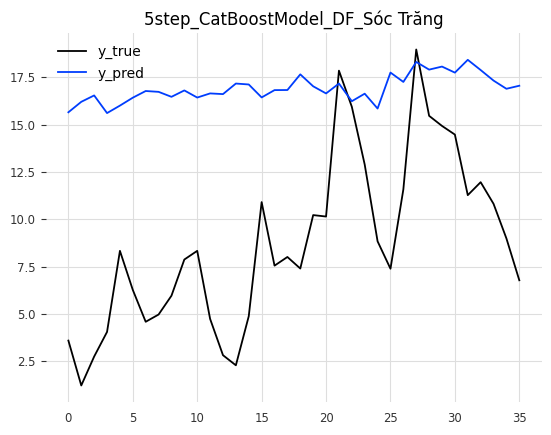

rmse,mae,mape,mse
9.15410447898193,8.243057049613778,1.7948222859219531,83.79762881211704
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 1447.0760
rmse: 38.04045255634748
mape: 17.504572711292266


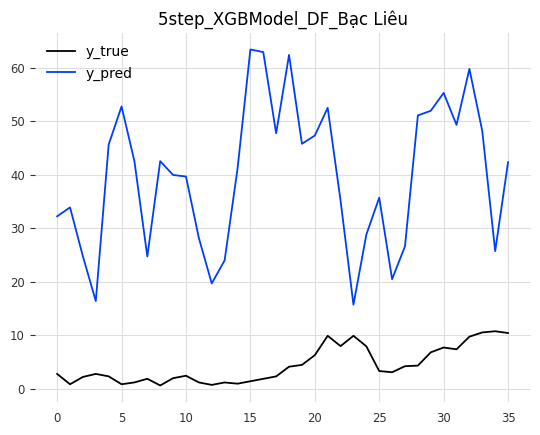

rmse,mae,mape,mse
38.04045255634748,35.53834086594819,17.504572711292266,1447.0760306917239
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 9800.4692
rmse: 98.99731931471388
mape: 16.130433432319663


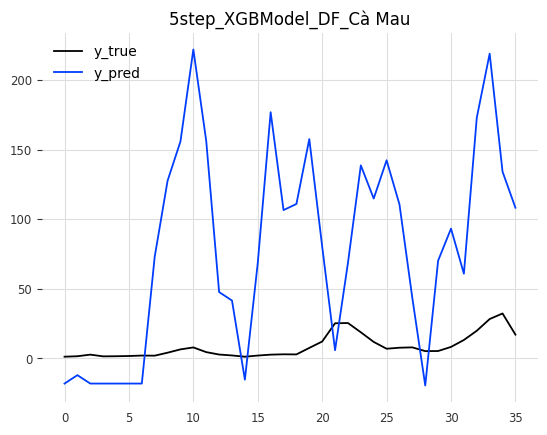

rmse,mae,mape,mse
98.99731931471388,81.49676340368624,16.130433432319663,9800.469231499423
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 4613.1716
rmse: 67.92033270751683
mape: 27.168416256177974


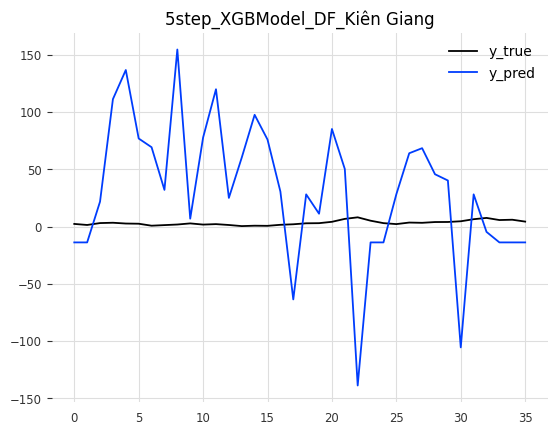

rmse,mae,mape,mse
67.92033270751683,53.88640640866804,27.168416256177974,4613.1715950997805
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 2662.9717
rmse: 51.60398964311376
mape: 6.96208233331215


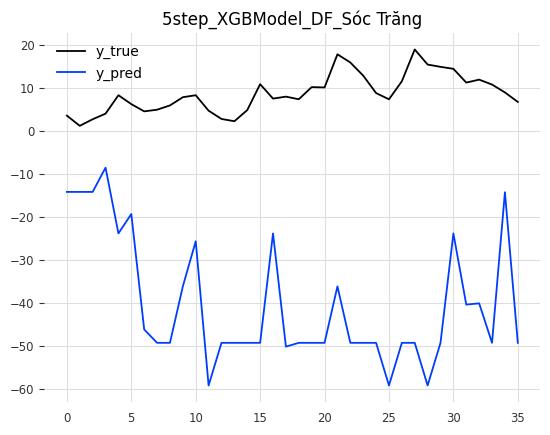

rmse,mae,mape,mse
51.60398964311376,48.87068473353587,6.96208233331215,2662.9717470865926
✨✨✨✨✨✨✨✨6✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 18.8119
rmse: 4.337265785554644
mape: 2.4739164762538604


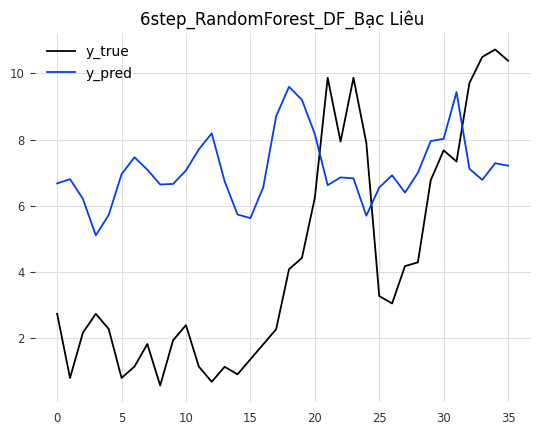

rmse,mae,mape,mse
4.337265785554644,3.982160551996319,2.4739164762538604,18.811874494542945
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 112.7177
rmse: 10.616856930311467
mape: 3.3798251965276145


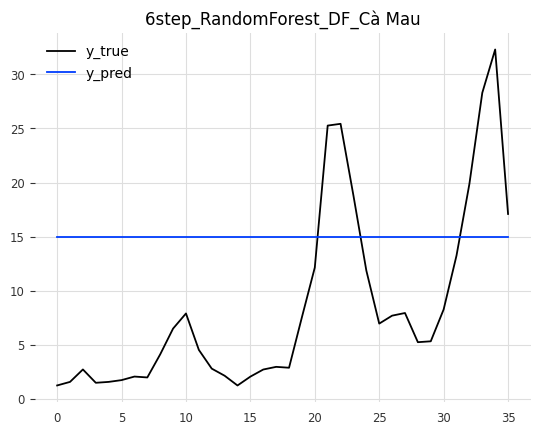

rmse,mae,mape,mse
10.616856930311467,9.886441646700476,3.3798251965276145,112.71765107870264
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 101.2511
rmse: 10.062360207756443
mape: 5.131293051648224


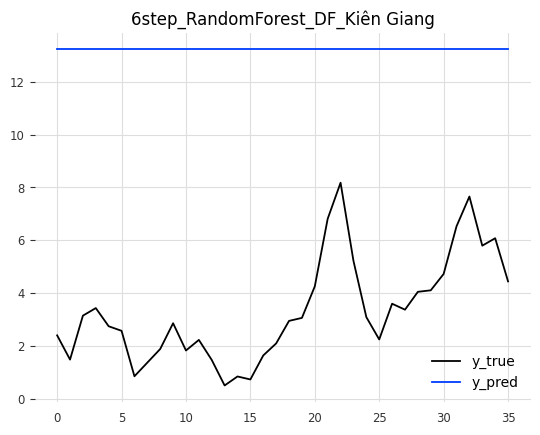

rmse,mae,mape,mse
10.062360207756443,9.870157666790789,5.131293051648224,101.2510929506403
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 237.3076
rmse: 15.404790075725275
mape: 1.4882033342866365


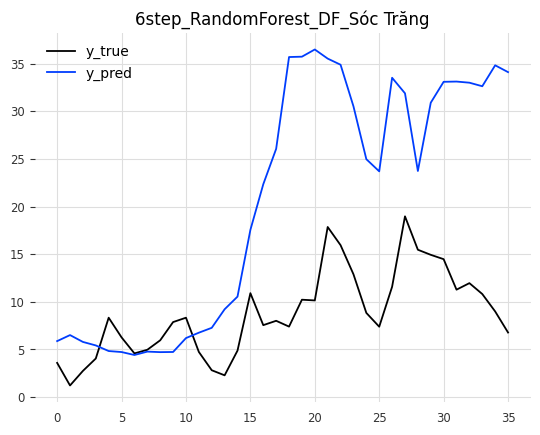

rmse,mae,mape,mse
15.404790075725275,12.352975704746742,1.4882033342866365,237.30755727716394
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 173.8305
rmse: 13.184481178112287
mape: 6.141712499755849


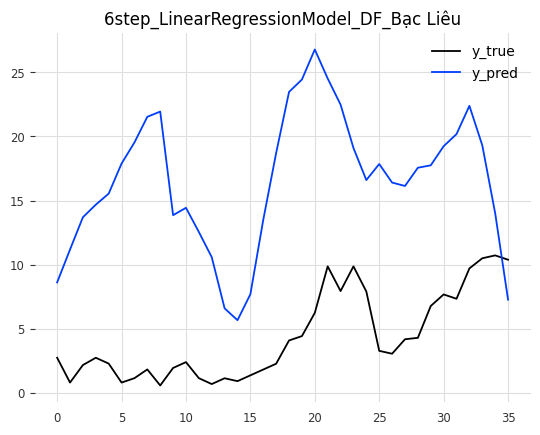

rmse,mae,mape,mse
13.184481178112287,12.306089572867535,6.141712499755849,173.83054393599716
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 232.5829
rmse: 15.250669443307839
mape: 3.644499955183621


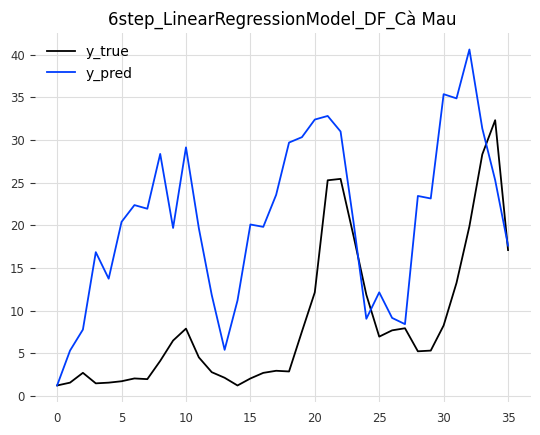

rmse,mae,mape,mse
15.250669443307839,12.713342113089988,3.644499955183621,232.58291846904345
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 332.5223
rmse: 18.23519292078292
mape: 6.925013002265989


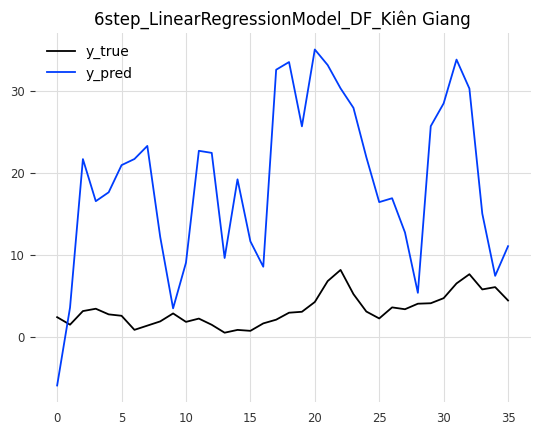

rmse,mae,mape,mse
18.23519292078292,16.085428541278873,6.925013002265989,332.5222608581716
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 233.7778
rmse: 15.289793447662243
mape: 2.0902243870374306


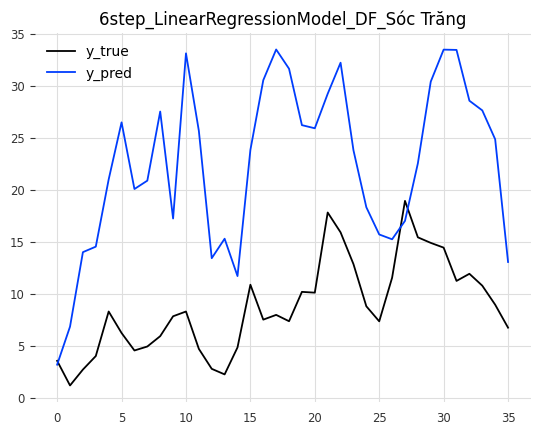

rmse,mae,mape,mse
15.289793447662243,13.858209939774369,2.0902243870374306,233.77778367217525
✨✨✨✨✨✨✨✨LightGBMModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.09392952859682162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09392952859682162
[LightGBM] [Warning] feature_fraction is set=0.7226181982511259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7226181982511259
[LightGBM] [Warning] lambda_l1 is set=0.09392952859682162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09392952859682162
[LightGBM] [Warning] feature_fraction is set=0.7226181982511259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7226181982511259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 195, number of u

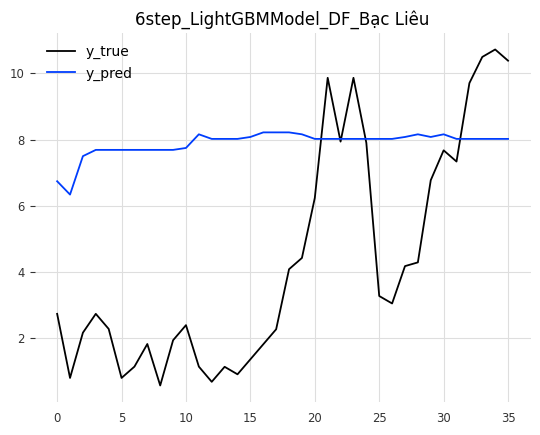

rmse,mae,mape,mse
4.805477808282228,4.247548919984415,2.8061509353561767,23.09261696589296
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.0006101916098751202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006101916098751202
[LightGBM] [Warning] feature_fraction is set=0.7772954441647505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7772954441647505
[LightGBM] [Warning] lambda_l1 is set=0.0006101916098751202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006101916098751202
[LightGBM] [Warning] feature_fraction is set=0.7772954441647505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7772954441647505
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 195, number of used features: 17
[LightGBM] [

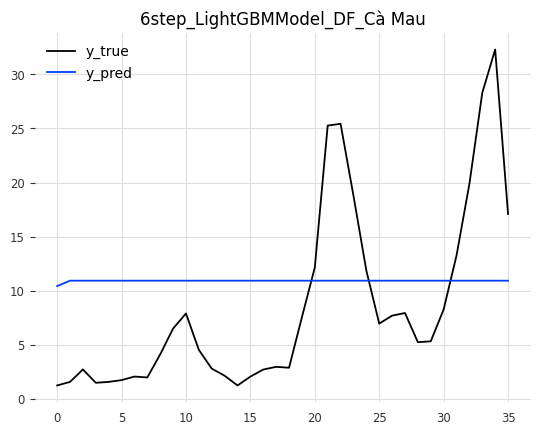

rmse,mae,mape,mse
8.769760944903544,7.655558221763782,2.3116882724203376,76.90870703075551
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.004409099146746784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004409099146746784
[LightGBM] [Warning] feature_fraction is set=0.9963203390472233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9963203390472233
[LightGBM] [Warning] lambda_l1 is set=0.004409099146746784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004409099146746784
[LightGBM] [Warning] feature_fraction is set=0.9963203390472233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9963203390472233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 195, number of used features: 17
[LightGBM] [

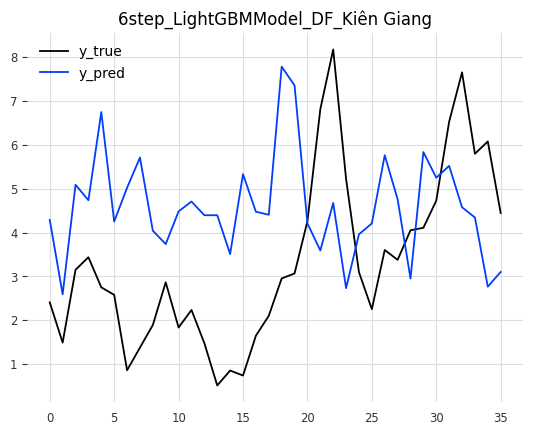

rmse,mae,mape,mse
2.68970054785962,2.3901662186743637,1.316488224412633,7.234489037156341
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.0237441419273487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0237441419273487
[LightGBM] [Warning] feature_fraction is set=0.5132829670775787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5132829670775787
[LightGBM] [Warning] lambda_l1 is set=0.0237441419273487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0237441419273487
[LightGBM] [Warning] feature_fraction is set=0.5132829670775787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5132829670775787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 195, number of used features: 14
[LightGBM] [Info] Star

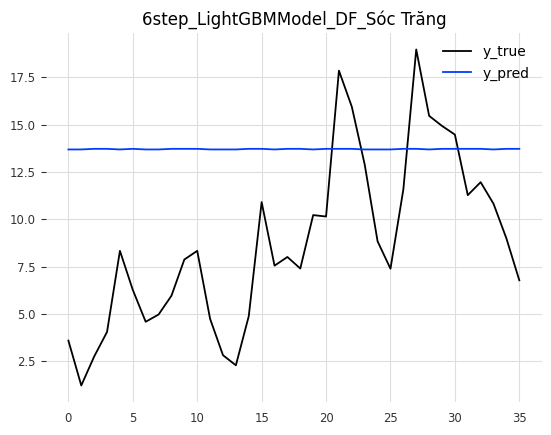

rmse,mae,mape,mse
6.662909669962189,5.808341492272593,1.3391706172839166,44.394365270075646
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 12.9339
rmse: 3.596369945969359
mape: 1.5921457232628862


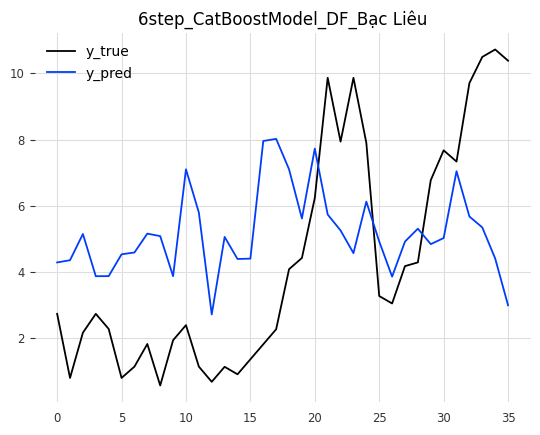

rmse,mae,mape,mse
3.596369945969359,3.1412898743648086,1.5921457232628862,12.933876788271649
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 63.1524
rmse: 7.9468465084694815
mape: 2.0765627975403866


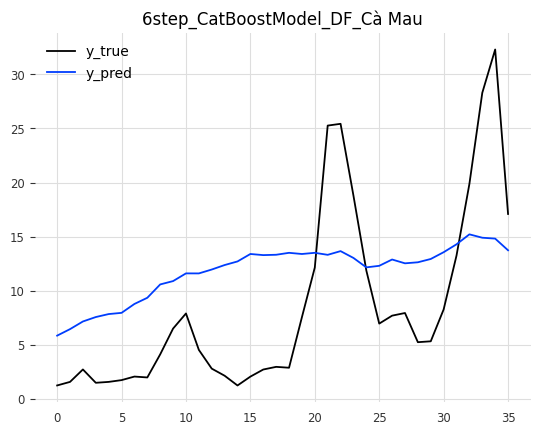

rmse,mae,mape,mse
7.9468465084694815,7.066737175226162,2.0765627975403866,63.15236942917358
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 58.7698
rmse: 7.666145328063943
mape: 3.986167794538888


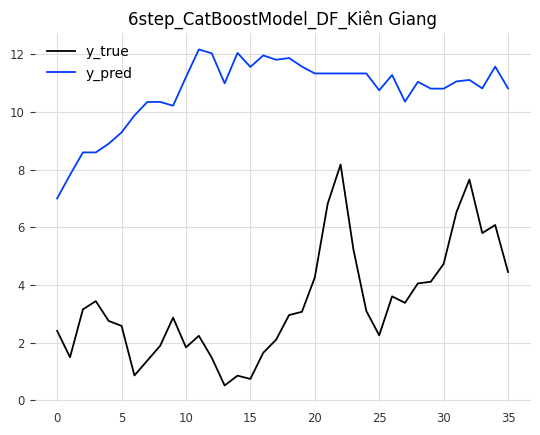

rmse,mae,mape,mse
7.666145328063943,7.359083081412523,3.986167794538888,58.769784190996624
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 34.7325
rmse: 5.893429978562817
mape: 1.0687628451504585


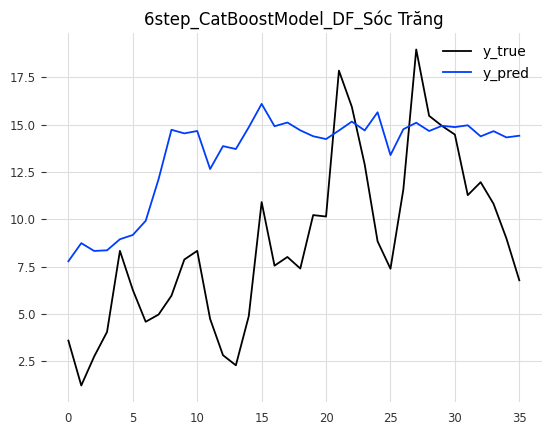

rmse,mae,mape,mse
5.893429978562817,5.129707773313126,1.0687628451504585,34.73251691222292
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bạc Liêu✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 2591.4183
rmse: 50.90597488705689
mape: 19.77010924705339


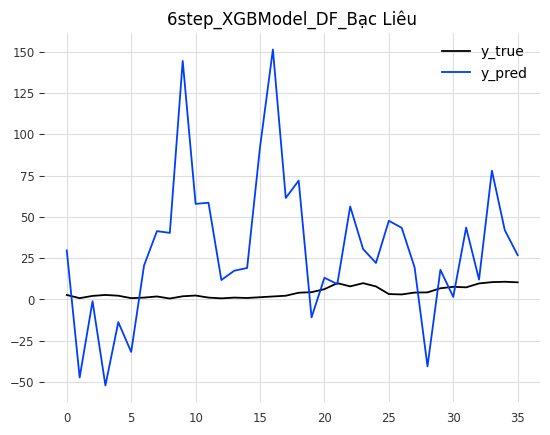

rmse,mae,mape,mse
50.90597488705689,38.05292537412444,19.77010924705339,2591.4182792016672
✨✨✨✨✨✨✨✨Cà Mau✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 1293.3319
rmse: 35.9629240114562
mape: 6.880685364559735


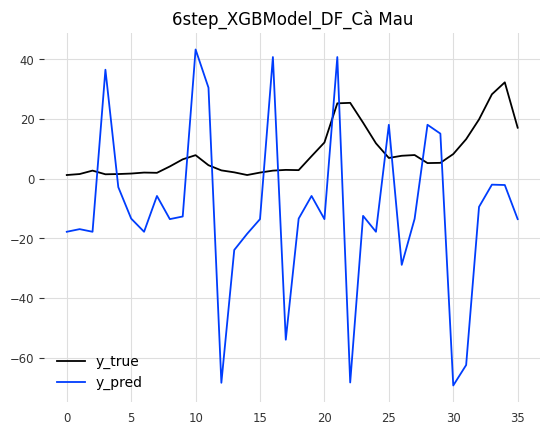

rmse,mae,mape,mse
35.9629240114562,29.476534296188635,6.880685364559735,1293.3319034537728
✨✨✨✨✨✨✨✨Kiên Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 4272.0700
rmse: 65.36107407478288
mape: 22.92629090685884


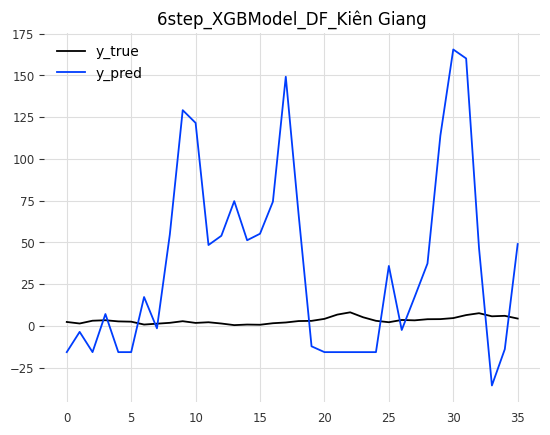

rmse,mae,mape,mse
65.36107407478288,48.31034773719616,22.92629090685884,4272.070004209255
✨✨✨✨✨✨✨✨Sóc Trăng✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 10630.1699
rmse: 103.10271536314531
mape: 15.06316984144773


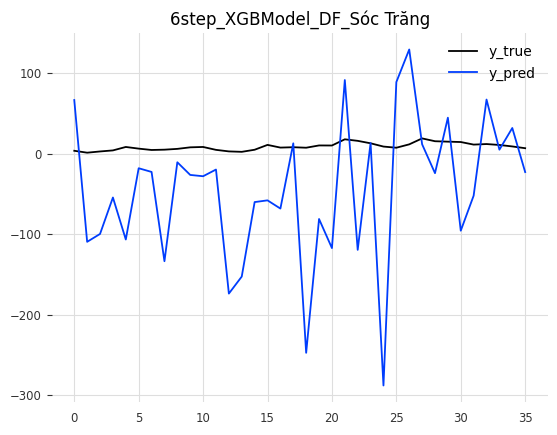

rmse,mae,mape,mse
103.10271536314531,78.9566605283583,15.06316984144773,10630.16991525376


In [32]:
model_name_list = [
     "RandomForest",
     "LinearRegressionModel",
     "LightGBMModel",
     "CatBoostModel",
     "XGBModel",
    # "PoissonRegressor",
    # "SVMRBF"
]

for nstep in range(1,args.n_predicted_period_months+1):
# for nstep in range(1,2):
    print(f"✨✨✨✨✨✨✨✨{nstep}✨✨✨✨✨✨✨✨✨✨")
    for model_name in model_name_list:   
        print(f"✨✨✨✨✨✨✨✨{model_name}✨✨✨✨✨✨✨✨✨✨")
        for city in cities:
            print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
            df_train = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            df_valid = pd.read_csv(output_process+city+'_test_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok
            is_sklearn_model = 0
            selected_features = getDataWithSelectedFeature(city, nstep)

            lags_by_nstep = args.look_back + nstep - 1
            lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
            is_dl_algo = 0

            pl_trainer_kwargs = {
                        "accelerator": "cpu",
                        # "devices": -1,
                        # "auto_select_gpus": True,
                    }

            df_hyper_params = getHyperParams(model_name, city, nstep)

            if model_name == "RandomForest":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the RandomForest model
                    model = RandomForest(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates_by_nstep,
                                    output_chunk_length = int(output_chunk_length),
                                    n_estimators = int(n_estimators),
                                    max_depth = int(max_depth),
                                    random_state=int(random_state))
            elif model_name == 'XGBModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    # Create the  model
                    model = XGBModel(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates,
                                    output_chunk_length = int(output_chunk_length),
                                    random_state=int(random_state),
                                    likelihood = likelihood
                                    )
            elif model_name == 'LinearRegressionModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the  model
                    model = LinearRegressionModel(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates,
                                    output_chunk_length = int(output_chunk_length),
                                    random_state=int(random_state))
            elif model_name == "CatBoostModel":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    bagging_temperature = df_hyper_params['bagging_temperature'].values[0]
                    border_count = df_hyper_params['border_count'].values[0]
                    l2_leaf_reg = df_hyper_params['l2_leaf_reg'].values[0]
                    random_strength = df_hyper_params['random_strength'].values[0]
                    opt_quantitles = df_hyper_params['quantiles'].values[0]
                    if opt_quantitles == "IsNone":
                        quantitles = None
                    else:
                        quantitles = df_hyper_params['quantiles'].values[0].split(',')
                    model = CatBoostModel(
                                            lags=int(lags),
                                            lags_past_covariates=lags_past_covariates, 
                                            learning_rate=float(learning_rate),
                                            n_estimators= int(n_estimators),
                                            max_depth=int(max_depth), 
                                            output_chunk_length = int(output_chunk_length),
                                            likelihood = likelihood,
                                            # quantiles = float(quantiles), #None or float
                                            bagging_temperature = float(bagging_temperature),
                                            # border_count = int(border_count),
                                            l2_leaf_reg = float(l2_leaf_reg),
                                            random_strength = float(random_strength),
                                            random_state=int(random_state))
            elif model_name == "LightGBMModel":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = 1
                    multi_models = df_hyper_params['multi_models'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    num_leaves = df_hyper_params['num_leaves'].values[0]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    feature_fraction = df_hyper_params['feature_fraction'].values[0]
                    min_child_samples = df_hyper_params['min_child_samples'].values[0]
                    lambda_l1 = df_hyper_params['lambda_l1'].values[0]
                    model = LightGBMModel(
                        lags =int(lags),
                        lags_past_covariates = lags_past_covariates,
                        output_chunk_length = int(output_chunk_length),
                        multi_models = bool(multi_models),
                        likelihood = likelihood,
                        num_leaves = int(num_leaves),
                        learning_rate = float(learning_rate),
                        feature_fraction = float(feature_fraction),
                        min_child_samples = int(min_child_samples),
                        lambda_l1 = float(lambda_l1),
                    )
            elif model_name == 'SVMRBF':
                    max_iter = df_hyper_params['max_iter'].values[0]
                    epsilon = df_hyper_params['epsilon'].values[0],
                    model = SVR(
                        max_iter = max_iter,
                        kernel = 'rbf',
                        epsilon = epsilon[0]
                    )
                    is_sklearn_model = 1
            elif model_name == "PoissonRegressor":
                    max_iter = df_hyper_params['max_iter'].values[0]
                    alpha = df_hyper_params['alpha'].values[0],
                    model = PoissonRegressor(
                        max_iter = max_iter,
                        fit_intercept = False,
                        alpha = alpha[0]
                    )
                    is_sklearn_model = 1        
            df, model = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
                                                            labels=args.labels, scaler=scaler, is_dl_algo = is_dl_algo,is_sklearn_model = is_sklearn_model, nstep = nstep,model_name = model_name)
             
            folder_save_rs_path = f"./predict_results/{model_name}/"
            folder_save_model_path = f"./trained_models/{model_name}/"
            if not (os.path.isdir(folder_save_rs_path)):
                os.makedirs(folder_save_rs_path, exist_ok=True)
            if not (os.path.isdir(folder_save_model_path)):
                os.makedirs(folder_save_model_path, exist_ok=True)
            df.to_excel(f"{folder_save_rs_path}0_train_{nstep}nstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
            pickle.dump(model, open(f"{folder_save_model_path}{nstep}nstep_denguefever_{model_name}_in_{city}.sav", 'wb'))